# Bloco 1: Importação de Bibliotecas e Configurações Iniciais
**Descrição:** Importa as bibliotecas necessárias para a análise (pandas, glob, numpy, matplotlib) e define configurações de exibição para o pandas, garantindo que mais colunas e linhas sejam mostradas nas saídas.

In [ ]:
#| classes: [fold-output]  # ( saída recolhível)
import pandas as pd
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

# Config exibição do Pandas
pd.options.display.max_columns = 100
pd.options.display.max_rows = 200

# Bloco 2: Carregamento e Leitura dos Dados de Estoque
**Descrição:** Localiza todos os arquivos CSV de estoque, define os tipos de dados para colunas e carrega e concatena todos os arquivos em um único DataFrame.

 <span style="color:red;"> Aviso importante, abra pra ler</span>

## Paths
**Atenção:** <span style="color:orange;">Redefina o Caminho para os arquivos</span>

In [18]:
caminho_feriados = r'C:\Users\Leo\Desktop\Porto_Real\portoauto\feriados_nacionais.xls'
patt = r'C:\Users\Leo\Desktop\Porto_Real\portoauto\data_temp\fct_2025-07-14\*Estoque*.csv'  

## colunas

In [ ]:
#| classes: [fold-output]  # ( saída recolhível)
list_files = glob(patt)
print("Arquivos encontrados:", list_files)

colunas_data = [
    'DataEmissao', 'DataAquisicao', 'DataVencimento', 'DataGeracao'
]

colunas_texto = [
    'Situacao', 'PES_TIPO_PESSOA', 'CedenteCnpjCpf', 'TIT_CEDENTE_ENT_CODIGO',
    'CedenteNome', 'Cnae', 'SecaoCNAEDescricao', 'NotaPdd', 'SAC_TIPO_PESSOA',
    'SacadoCnpjCpf', 'SacadoNome', 'IdTituloVortx', 'TipoAtivo', 'NumeroBoleto',
    'NumeroTitulo', 'CampoChave', 'PagamentoParcial', 'Coobricacao',
    'CampoAdicional1', 'CampoAdicional2', 'CampoAdicional3', 'CampoAdicional4',
    'CampoAdicional5', 'IdTituloVortxOriginador', 'Registradora',
    'IdContratoRegistradora', 'IdTituloRegistradora', 'CCB', 'Convênio'
]


dtype_texto = {col: str for col in colunas_texto}
"""dic de tips para colns de texto"""



Arquivos encontrados: ['C:\\Users\\Leo\\Desktop\\Porto_Real\\portoauto\\data_temp\\fct_2025-07-14\\FIDC FCT CONSIGNADO II  - Estoque 14.07.25-Parte1.csv', 'C:\\Users\\Leo\\Desktop\\Porto_Real\\portoauto\\data_temp\\fct_2025-07-14\\FIDC FCT CONSIGNADO II  - Estoque 14.07.25-Parte2.csv', 'C:\\Users\\Leo\\Desktop\\Porto_Real\\portoauto\\data_temp\\fct_2025-07-14\\FIDC FCT CONSIGNADO II  - Estoque 14.07.25-Parte3.csv', 'C:\\Users\\Leo\\Desktop\\Porto_Real\\portoauto\\data_temp\\fct_2025-07-14\\FIDC FCT CONSIGNADO II  - Estoque 14.07.25-Parte4.csv']


'dic de tips para colns de texto'

## Leitura e Concatenacao

In [ ]:
#| classes: [fold-output]  # ( saída recolhível)
dfs = []
for file in list_files:
    print(f"Lendo o arquivo: {file}")
    df_ = pd.read_csv(file, sep=';', encoding='latin1', dtype=dtype_texto,
                      decimal=',', parse_dates=colunas_data, dayfirst=True)
    dfs.append(df_)

df_final = pd.concat(dfs, ignore_index=True)
print("Leitura e concatenação concluídas.")

Lendo o arquivo: C:\Users\Leo\Desktop\Porto_Real\portoauto\data_temp\fct_2025-07-14\FIDC FCT CONSIGNADO II  - Estoque 14.07.25-Parte1.csv
Lendo o arquivo: C:\Users\Leo\Desktop\Porto_Real\portoauto\data_temp\fct_2025-07-14\FIDC FCT CONSIGNADO II  - Estoque 14.07.25-Parte2.csv
Lendo o arquivo: C:\Users\Leo\Desktop\Porto_Real\portoauto\data_temp\fct_2025-07-14\FIDC FCT CONSIGNADO II  - Estoque 14.07.25-Parte3.csv
Lendo o arquivo: C:\Users\Leo\Desktop\Porto_Real\portoauto\data_temp\fct_2025-07-14\FIDC FCT CONSIGNADO II  - Estoque 14.07.25-Parte4.csv
Leitura e concatenação concluídas.


# Bloco 3: Criação de Colunas Auxiliares
(para facilitar análises)
- `_ValorLiquido`: Valor Presente ajustado pelo PDD. (-PDDTOTAL)
- `_ValorVencido`: Identifica o valor de títulos já vencidos. ()
- `_MuitosContratos`: Flag para sacados com um número elevado de contratos (CCB).
- `_MuitosEntes`: Flag para sacados associados a múltiplos convênios.

In [ ]:
#| classes: [fold-output] 
# ( saída recolhível)
# Criar colunas aux
df_final['_ValorLiquido'] = df_final['ValorPresente'] - df_final['PDDTotal']

df_final['_ValorVencido'] = (df_final['DataVencimento'] <= df_final['DataGeracao']).astype('int') * df_final['ValorPresente']

# * sacados com muitos contratos (CCB)
sacado_contratos = df_final.groupby('SacadoNome')['CCB'].nunique()
k = 3
mask_contratos = sacado_contratos >= k
sacado_contratos_alto = sacado_contratos[mask_contratos].index
df_final['_MuitosContratos'] = df_final['SacadoNome'].isin(sacado_contratos_alto).astype(str)

#*  sacados com muitos entes (Convênios)
sacados_entes = df_final.groupby('SacadoCnpjCpf')['Convênio'].nunique()
k2 = 3
mask_entes = sacados_entes >= k2
sacados_entes_alto = sacados_entes[mask_entes].index
df_final['_MuitosEntes'] = df_final['SacadoCnpjCpf'].isin(sacados_entes_alto).astype(str)

print("Criação de colunas auxiliares concluída.")

Criação de colunas auxiliares concluída.


# Bloco 4: Verificação Inicial do DataFrame
**Descrição:** Realiza uma verificação rápida do DataFrame, mostrando o uso de memória e o valor total do estoque (Valor Presente).

In [ ]:
#| classes: [fold-output] 
# ( saída recolhível)
memoria_mb = df_final.memory_usage(deep=True).sum() / 1024**2
print(f"Uso de memória do DataFrame: {memoria_mb:.2f} MB")

valor_total_estoque = df_final["ValorPresente"].sum()
print(f"Valor Presente Total do Estoque: R$ {valor_total_estoque:_.2f}".replace('.', ',').replace('_', '.'))

Uso de memória do DataFrame: 2733.50 MB
Valor Presente Total do Estoque: R$ 199.232.147,56


# Bloco 5: Análise Exploratória Geral Contagens
**Descrição:** Itera sobre as colunas de texto para entender a distribuição de suas categorias. As perguntas no comentário guiam esta exploração.

<span style="color:yellow;"> **Questões para investigação:** </span>
1.  `[Situacao]` - diferença entre sem cobrança e aditado
2.  `[SAC_TIPO_PESSOA]` - tipo J = jurídico?? tem isso?
3.  `[SacadoCnpjCpf]` - por que tem CNPJ?
4.  `[SacadoNome]` 'BMP SOCIEDADE DE CREDITO DIRETO S.A'
5.  `[SacadoCnpjCpf']` - verificar consistência dos CPFs
6.  `[TipoAtivo]` - CCB e Contrato. Por que tem contrato?
7.  `[DataGeracao]` - data de referência ou data de processamento?
8.  `[SacadoCnpjCpf]` - tem sacado com 1040 linhas (!)
9.  `[Convênio]` - sacados com muitos convênios (3)

In [ ]:
#| classes: [fold-output] 
# ( saída recolhível)
df_final2 = df_final[~df_final['Situacao'].isna()].copy()

print("Analisando a contagem de valores para colunas de texto (geral):")
for col in df_final2.select_dtypes(include=['object']).columns:
    print(f"--- Análise da coluna: {col} ---")
    print(df_final2[col].value_counts(dropna=False))
    print('*' * 80)

Analisando a contagem de valores para colunas de texto (geral):
--- Análise da coluna: Situacao ---
Situacao
Sem cobranÃ§a    1471376
Aditado            50939
Name: count, dtype: int64
********************************************************************************
--- Análise da coluna: PES_TIPO_PESSOA ---
PES_TIPO_PESSOA
J    1522315
Name: count, dtype: int64
********************************************************************************
--- Análise da coluna: CedenteCnpjCpf ---
CedenteCnpjCpf
34.337.707/0001-00    1519907
92.874.270/0001-40       2408
Name: count, dtype: int64
********************************************************************************
--- Análise da coluna: TIT_CEDENTE_ENT_CODIGO ---
TIT_CEDENTE_ENT_CODIGO
318853     1519907
3224693       2408
Name: count, dtype: int64
********************************************************************************
--- Análise da coluna: CedenteNome ---
CedenteNome
BMP MONEY PLUS SOCIEDADE DE CREDITO DIRETO S.A    1519907
BANC

# Bloco 6: Verificação do Impacto de Linhas com 'Situacao' Nula
**Descrição:** Analisa se as linhas com 'Situacao' nula têm impacto significativo no cálculo do Valor Presente total.

In [ ]:
#| classes: [fold-output] 
# ( saída recolhível)
print("Verificando o impacto das linhas com 'Situacao' nula...")
v1_ = df_final['ValorPresente'].sum()
v2_ = df_final[~df_final['Situacao'].isna()]['ValorPresente'].sum()
print(f"Valores são próximos? {np.isclose(v1_, v2_)}")

# Libera memória
del df_final

Verificando o impacto das linhas com 'Situacao' nula...
Valores são próximos? True


# Bloco 7: Análise de Sacados com SAC_TIPO_PESSOA == 'J'
**Descrição:** Isola e analisa registros onde o tipo de sacado é 'J'.

In [ ]:
#| classes: [fold-output] 
# ( saída recolhível)
print("Analisando sacados com tipo 'J'...")
df_sacado_J = df_final2[df_final2['SAC_TIPO_PESSOA'] == 'J']
if not df_sacado_J.empty:
    print("Tamanhos de 'SacadoCnpjCpf' para tipo 'J':", df_sacado_J['SacadoCnpjCpf'].map(len).unique())
    display(df_sacado_J.sample(min(5, len(df_sacado_J))))
else:
    print("Nenhum sacado do tipo 'J' encontrado.")

Analisando sacados com tipo 'J'...
Tamanhos de 'SacadoCnpjCpf' para tipo 'J': [14 18]


,Situacao,PES_TIPO_PESSOA,CedenteCnpjCpf,TIT_CEDENTE_ENT_CODIGO,CedenteNome,Cnae,SecaoCNAEDescricao,NotaPdd,SAC_TIPO_PESSOA,SacadoCnpjCpf,SacadoNome,IdTituloVortx,TipoAtivo,DataEmissao,DataAquisicao,DataVencimento,NumeroBoleto,NumeroTitulo,CampoChave,ValorAquisicao,ValorNominal,ValorPresente,PDDNota,PDDVencido,PagamentoParcial,Coobricacao,DataGeracao,PDDTotal,CampoAdicional1,CampoAdicional2,CampoAdicional3,CampoAdicional4,CampoAdicional5,PDDEfeitoVagao,PercentagemEfeitoVagao,IdTituloVortxOriginador,Registradora,IdContratoRegistradora,IdTituloRegistradora,CCB,Convênio,_ValorLiquido,_ValorVencido,_MuitosContratos,_MuitosEntes
217479,Sem cobranÃ§a,J,34.337.707/0001-00,318853,BMP MONEY PLUS SOCIEDADE DE CREDITO DIRETO S.A,6499999,OUTRAS ATIVIDADES DE SERVIÃOS FINANCEIROS NÃ...,AA,J,128.087.503-82,JOAO FRANCISCO DA SILVA TINOCO,35079091,CCB,2024-02-23,2024-02-26,2027-03-02,NaN,3271329536,31583364,37.90,86.99,55.4955,0.0,0.0,NAO,NAO,2025-07-14,55.4955,NaN,NaN,NaN,NaN,NaN,55.495500,1.0,35079298,NaN,NaN,NaN,32713295,GOV. MARANHAO,0.0000,0.0,False,False
256609,Aditado,J,34.337.707/0001-00,318853,BMP MONEY PLUS SOCIEDADE DE CREDITO DIRETO S.A,6499999,OUTRAS ATIVIDADES DE SERVIÃOS FINANCEIROS NÃ...,AA,J,432.189.203-10,JACSON RODRIGUES RIBEIRO,50976079,CCB,2024-08-08,2024-08-09,2028-05-29,NaN,3905044844,180325492,308.28,751.97,383.4619,0.0,0.0,NAO,NAO,2025-07-14,0.0000,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0,NaN,NaN,NaN,39050448,GOV. MARANHAO,383.4619,0.0,False,False
556256,Sem cobranÃ§a,J,34.337.707/0001-00,318853,BMP MONEY PLUS SOCIEDADE DE CREDITO DIRETO S.A,6499999,OUTRAS ATIVIDADES DE SERVIÃOS FINANCEIROS NÃ...,AA,J,972.313.122-68,REGINALDO TOBIAS DA SILVA,37727747,CCB,2024-04-16,2024-04-17,2026-11-20,NaN,3456100430,69114635,89.50,206.58,133.3823,0.0,0.0,NAO,NAO,2025-07-14,92.0973,NaN,NaN,NaN,NaN,NaN,92.097302,0.0,72691961,NaN,NaN,NaN,34561004,PREF. CASTANHAL,41.2850,0.0,False,False
1427200,Sem cobranÃ§a,J,34.337.707/0001-00,318853,BMP MONEY PLUS SOCIEDADE DE CREDITO DIRETO S.A,6499999,OUTRAS ATIVIDADES DE SERVIÃOS FINANCEIROS NÃ...,AA,J,864.020.563-91,CRISTIANO PESSOA LAGES,85697661,CCB,2025-03-14,2025-03-17,2027-10-25,NaN,50868815030,50868815030,29.07,63.64,32.0324,0.0,0.0,NAO,NAO,2025-07-14,0.0000,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0,NaN,NaN,NaN,50868815,GOV. MARANHAO,32.0324,0.0,False,False
277554,Sem cobranÃ§a,J,34.337.707/0001-00,318853,BMP MONEY PLUS SOCIEDADE DE CREDITO DIRETO S.A,6499999,OUTRAS ATIVIDADES DE SERVIÃOS FINANCEIROS NÃ...,AA,J,051.192.813-03,YURI BARBOSA MARTINS,103435081,CCB,2025-07-02,2025-07-03,2026-11-26,NaN,58752870015,58752870015,170.26,259.28,171.6899,0.0,0.0,NAO,NAO,2025-07-14,0.0000,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0,NaN,NaN,NaN,58752870,GOV. MARANHAO,171.6899,0.0,True,False


# Bloco 8: Análise Específica de Sacados com CNPJ
**Descrição:** Filtra sacados com CNPJ e realiza uma análise detalhada sobre eles, incluindo uma nova verificação de value_counts() para todas as colunas categóricas dentro deste subconjunto.

In [ ]:
#| classes: [fold-output] 
# ( saída recolhível)
print("Analisando sacados com CNPJ...")
df_final2_cnpj = df_final2[df_final2['SacadoCnpjCpf'].map(len) == 18].copy()

if not df_final2_cnpj.empty:
    print("\nNomes únicos de sacados com CNPJ:")
    print(df_final2_cnpj['SacadoNome'].unique())

    print("\n--- value_counts() para o subconjunto de Sacados com CNPJ ---")
    for col in df_final2_cnpj.select_dtypes(include=['object']).columns:
        print(f"--- Análise da coluna: {col} (Apenas CNPJ) ---")
        print(df_final2_cnpj[col].value_counts(dropna=False))
        print('*'*80)

    print("\nEstatísticas descritivas para dados numéricos de sacados com CNPJ:")
    display(df_final2_cnpj.describe(include=[np.number]))

    print("\nSoma dos valores numéricos:")
    display(df_final2_cnpj.select_dtypes(include=[np.number]).sum())

    # Exportar para Excel
    # df_final2_cnpj.to_excel('df_final2_cnpj.xlsx')
else:
    print("Nenhum sacado com formato de CNPJ (18 caracteres) encontrado.")

Analisando sacados com CNPJ...

Nomes únicos de sacados com CNPJ:
['BMP SOCIEDADE DE CREDITO DIRETO S.A']

--- value_counts() para o subconjunto de Sacados com CNPJ ---
--- Análise da coluna: Situacao (Apenas CNPJ) ---
Situacao
Sem cobranÃ§a    95
Name: count, dtype: int64
********************************************************************************
--- Análise da coluna: PES_TIPO_PESSOA (Apenas CNPJ) ---
PES_TIPO_PESSOA
J    95
Name: count, dtype: int64
********************************************************************************
--- Análise da coluna: CedenteCnpjCpf (Apenas CNPJ) ---
CedenteCnpjCpf
34.337.707/0001-00    95
Name: count, dtype: int64
********************************************************************************
--- Análise da coluna: TIT_CEDENTE_ENT_CODIGO (Apenas CNPJ) ---
TIT_CEDENTE_ENT_CODIGO
318853    95
Name: count, dtype: int64
********************************************************************************
--- Análise da coluna: CedenteNome (Apenas CNPJ

,ValorAquisicao,ValorNominal,ValorPresente,PDDNota,PDDVencido,PDDTotal,PDDEfeitoVagao,PercentagemEfeitoVagao,_ValorLiquido,_ValorVencido
count,95.000000,9.500000e+01,95.000000,95.0,95.000000,95.000000,95.000000,95.0,95.0,95.000000
mean,23.177368,5.613000e+01,27.604434,0.0,1.650542,27.604434,27.604434,1.0,0.0,4.135895
std,13.054230,1.428624e-14,15.121244,0.0,8.263526,15.121244,15.121244,0.0,0.0,14.742111
min,7.310000,5.613000e+01,8.795000,0.0,0.000000,8.795000,8.795000,1.0,0.0,0.000000
25%,12.005000,5.613000e+01,14.445900,0.0,0.000000,14.445900,14.445900,1.0,0.0,0.000000
50%,19.710000,5.613000e+01,23.720600,0.0,0.000000,23.720600,23.720600,1.0,0.0,0.000000
75%,32.350000,5.613000e+01,38.939150,0.0,0.000000,38.939150,38.939150,1.0,0.0,0.000000
max,53.070000,5.613000e+01,56.130000,0.0,56.130000,56.130000,56.130000,1.0,0.0,56.130000



Soma dos valores numéricos:


ValorAquisicao            2201.8500
ValorNominal              5332.3500
ValorPresente             2622.4212
PDDNota                      0.0000
PDDVencido                 156.8015
PDDTotal                  2622.4212
PDDEfeitoVagao            2622.4212
PercentagemEfeitoVagao      95.0000
_ValorLiquido                0.0000
_ValorVencido              392.9100
dtype: float64

# Bloco 9: Validação de CPFs na Coluna 'SacadoCnpjCpf'
**Descrição:** Aplica uma função para validar a estrutura matemática de CPFs.

In [ ]:
#| classes: [fold-output] 
# ( saída recolhível)
def validar_cpf(cpf):
    """Função para validar um número de CPF."""
    #? note que ela nao ta dando fill à esquerda- o que nao importa tanto pq a string tá completa
    cpf = ''.join(filter(str.isdigit, str(cpf)))
    if len(cpf) != 11 or cpf == cpf[0] * 11: return False
    soma = sum(int(cpf[i]) * (10 - i) for i in range(9))
    resto = (soma * 10) % 11
    if resto == 10: resto = 0
    if resto != int(cpf[9]): return False
    soma = sum(int(cpf[i]) * (11 - i) for i in range(10))
    resto = (soma * 10) % 11
    if resto == 10: resto = 0
    if resto != int(cpf[10]): return False
    return True

mask_cpf = df_final2['SacadoCnpjCpf'].map(len) == 14
df_final2['CPF_válido'] = False
df_final2.loc[mask_cpf, 'CPF_válido'] = df_final2.loc[mask_cpf, 'SacadoCnpjCpf'].apply(validar_cpf)
cpfs_invalidos = df_final2[(mask_cpf) & (~df_final2['CPF_válido'])]['SacadoCnpjCpf'].unique()
print(f"Encontrados {len(cpfs_invalidos)} CPFs com estrutura inválida.")

Encontrados 0 CPFs com estrutura inválida.


# Bloco 10: Análise do Percentual de PDD por Variável Categórica
**Descrição:** Calcula o percentual de PDD agrupado por diversas variáveis categóricas para identificar categorias de maior risco.

In [ ]:
#| classes: [fold-output] 
# ( saída recolhível)
cat_cols = [
    'Situacao', 'CedenteNome', 'SAC_TIPO_PESSOA', 'PagamentoParcial',
    'TipoAtivo', '_MuitosContratos', '_MuitosEntes', 'Convênio'
]

pdd_ref = (1 - df_final2['_ValorLiquido'].sum() / df_final2['ValorPresente'].sum()) * 100
print(f"PDD de Referência (Total): {pdd_ref:.2f}%\n")

for col in cat_cols:
    print(f"--- Análise de PDD por '{col}' ---")
    aux_ = df_final2.groupby(col)[['_ValorLiquido', 'ValorPresente']].sum() / 1e6
    aux_['%PDD'] = (1 - aux_['_ValorLiquido'] / aux_['ValorPresente']) * 100
    if col == 'Convênio':
        aux_ = aux_.sort_values('ValorPresente', ascending=False)
    display(aux_.head(20))
    print("\n" + "="*80 + "\n")

PDD de Referência (Total): 19.97%

--- Análise de PDD por 'Situacao' ---


,_ValorLiquido,ValorPresente,%PDD
Situacao,,,
Aditado,7.851224,8.081707,2.851911
Sem cobranÃ§a,151.600857,191.150441,20.690292




--- Análise de PDD por 'CedenteNome' ---


,_ValorLiquido,ValorPresente,%PDD
CedenteNome,,,
BANCO DIGIMAIS S.A.,0.246985,0.297263,16.913659
BMP MONEY PLUS SOCIEDADE DE CREDITO DIRETO S.A,159.205096,198.934885,19.971253




--- Análise de PDD por 'SAC_TIPO_PESSOA' ---


,_ValorLiquido,ValorPresente,%PDD
SAC_TIPO_PESSOA,,,
F,130.019122,150.625730,13.680669
J,29.432959,48.606418,39.446353




--- Análise de PDD por 'PagamentoParcial' ---


,_ValorLiquido,ValorPresente,%PDD
PagamentoParcial,,,
NAO,159.39059,198.993242,19.901506
SIM,0.06149,0.238906,74.261624




--- Análise de PDD por 'TipoAtivo' ---


,_ValorLiquido,ValorPresente,%PDD
TipoAtivo,,,
CCB,150.961799,190.277251,20.662192
CT - Contrato,8.490281,8.954897,5.188396




--- Análise de PDD por '_MuitosContratos' ---


,_ValorLiquido,ValorPresente,%PDD
_MuitosContratos,,,
False,137.633688,170.629483,19.337687
True,21.818393,28.602664,23.719020




--- Análise de PDD por '_MuitosEntes' ---


,_ValorLiquido,ValorPresente,%PDD
_MuitosEntes,,,
False,159.436245,199.208493,19.965137
True,0.015835,0.023654,33.054812




--- Análise de PDD por 'Convênio' ---


,_ValorLiquido,ValorPresente,%PDD
Convênio,,,
GOV. MARANHAO,41.484712,46.568145,10.916117
GOV. ALAGOAS,32.999110,34.786090,5.137055
GOV. GOIAS,13.734775,17.185891,20.081099
PREF. BARREIRAS,9.304598,9.363838,0.632651
PREF. CABO FRIO,2.354433,6.814405,65.449174
GOV. RIO GRANDE DO NORTE,6.043314,6.765837,10.678985
PREF. CAMPOS DOS GOYTACAZES,4.330700,6.313879,31.409832
PREF. BALSAS,5.092831,5.119877,0.528237
GOV. TOCANTINS,2.902283,5.105860,43.157807


# Bloco 11: Análise do Percentual de Títulos Vencidos por Variável Categórica
**Descrição:** Calcula a proporção do valor vencido em relação ao Valor Presente para cada categoria, identificando os grupos com maior inadimplência.

In [ ]:
#| classes: [fold-output] 
# ( saída recolhível)
venc_ref = (df_final2['_ValorVencido'].sum() / df_final2['ValorPresente'].sum()) * 100
print(f"Percentual de Vencidos de Referência (Total): {venc_ref:.2f}%\n")

for col in cat_cols:
    print(f"--- Análise de Vencidos por '{col}' ---")
    aux_ = df_final2.groupby(col)[['_ValorVencido', 'ValorPresente']].sum() / 1e6
    aux_['%Vencido'] = (aux_['_ValorVencido'] / aux_['ValorPresente']) * 100
    if col == 'Convênio':
        aux_ = aux_.sort_values('ValorPresente', ascending=False)
    else:
        aux_ = aux_.sort_values('%Vencido', ascending=False)
    display(aux_.head(20))
    print("\n" + "="*80 + "\n")

Percentual de Vencidos de Referência (Total): 5.12%

--- Análise de Vencidos por 'Situacao' ---


,_ValorVencido,ValorPresente,%Vencido
Situacao,,,
Sem cobranÃ§a,10.165953,191.150441,5.318299
Aditado,0.038819,8.081707,0.480327




--- Análise de Vencidos por 'CedenteNome' ---


,_ValorVencido,ValorPresente,%Vencido
CedenteNome,,,
BANCO DIGIMAIS S.A.,0.019911,0.297263,6.698064
BMP MONEY PLUS SOCIEDADE DE CREDITO DIRETO S.A,10.184861,198.934885,5.119696




--- Análise de Vencidos por 'SAC_TIPO_PESSOA' ---


,_ValorVencido,ValorPresente,%Vencido
SAC_TIPO_PESSOA,,,
J,3.922586,48.606418,8.070099
F,6.282185,150.625730,4.170725




--- Análise de Vencidos por 'PagamentoParcial' ---


,_ValorVencido,ValorPresente,%Vencido
PagamentoParcial,,,
SIM,0.236883,0.238906,99.153147
NAO,9.967889,198.993242,5.009160




--- Análise de Vencidos por 'TipoAtivo' ---


,_ValorVencido,ValorPresente,%Vencido
TipoAtivo,,,
CCB,9.932005,190.277251,5.219754
CT - Contrato,0.272766,8.954897,3.046001




--- Análise de Vencidos por '_MuitosContratos' ---


,_ValorVencido,ValorPresente,%Vencido
_MuitosContratos,,,
False,8.923531,170.629483,5.229771
True,1.281240,28.602664,4.479443




--- Análise de Vencidos por '_MuitosEntes' ---


,_ValorVencido,ValorPresente,%Vencido
_MuitosEntes,,,
True,0.001815,0.023654,7.672974
False,10.202956,199.208493,5.121748




--- Análise de Vencidos por 'Convênio' ---


,_ValorVencido,ValorPresente,%Vencido
Convênio,,,
GOV. MARANHAO,0.909802,46.568145,1.953700
GOV. ALAGOAS,1.368971,34.786090,3.935397
GOV. GOIAS,1.110039,17.185891,6.459012
PREF. BARREIRAS,0.018141,9.363838,0.193732
PREF. CABO FRIO,0.873612,6.814405,12.820073
GOV. RIO GRANDE DO NORTE,0.177908,6.765837,2.629507
PREF. CAMPOS DOS GOYTACAZES,0.449292,6.313879,7.115950
PREF. BALSAS,0.009430,5.119877,0.184182
GOV. TOCANTINS,0.499738,5.105860,9.787537


# Bloco 12: Verificação de Sacados Presentes em Múltiplos Convênios ('Entes')
**Descrição:** Identifica sacados com pulverização entre diferentes parceiros.

In [ ]:
#| classes: [fold-output] 
# ( saída recolhível)

print("Analisando sacados presentes em múltiplos convênios...")
sacados_multi_entes = df_final2.groupby('SacadoCnpjCpf')['Convênio'].agg(['nunique', pd.unique])
sacados_multi_entes = sacados_multi_entes.sort_values('nunique', ascending=False)
display(sacados_multi_entes.head(35))

Analisando sacados presentes em múltiplos convênios...


,nunique,unique
SacadoCnpjCpf,,
048.692.204-90,3,"[GOV. GOIAS, PREF. TUTOIA, GOV. RIO GRANDE DO ..."
323.026.574-20,3,"[GOV. GOIAS, GOV. SÃO PAULO, GOV. RIO GRANDE D..."
292.798.363-15,2,"[GOV. MARANHAO, PREF. BALSAS]"
443.808.794-53,2,"[PREF. SÃO JOSÉ DE MIPIBU, GOV. RIO GRANDE DO ..."
813.733.763-68,2,"[GOV. MARANHAO, PREF. BALSAS]"
647.592.703-10,2,"[GOV. MARANHAO, PREF. SÃO LUIS]"
082.249.978-98,2,"[GOV. RIO GRANDE DO NORTE, PREF. SÃO JOSÉ DE M..."
054.906.964-00,2,"[GOV. RIO GRANDE DO NORTE, PREF. CAMPOS DOS GO..."
268.919.048-62,2,"[PREF. MAUÁ, PREF. SANTO ANDRE]"


# Bloco 13: Verificação de Consistência das Datas
**Descrição:** Realiza verificações do tipo *"sanity check"* (algo que deveria ser óbvio) nas colunas de data.

In [ ]:
#| classes: [fold-output] 
# ( saída recolhível)

print("Verificando consistência das datas...")
check1 = (df_final2['DataEmissao'] > df_final2['DataAquisicao']).sum()
print(f"Registros com Data de Emissão > Data de Aquisição: {check1}")
check2 = (df_final2['DataAquisicao'] > df_final2['DataVencimento']).sum()
print(f"Registros com Data de Aquisição > Data de Vencimento: {check2}")

Verificando consistência das datas...
Registros com Data de Emissão > Data de Aquisição: 0
Registros com Data de Aquisição > Data de Vencimento: 0


# Bloco 14: Verificação de Consistência dos Valores Monetários
**Descrição:** R"sanity check" nos valores financeiros.

In [ ]:
#| classes: [fold-output] 
# ( saída recolhível)

print("\nVerificando consistência dos valores...")
check_v1 = (df_final2['ValorAquisicao'] > df_final2['ValorNominal']).sum()
print(f"Registros com Valor de Aquisição > Valor Nominal: {check_v1}")
check_v2 = (df_final2['ValorAquisicao'] > df_final2['ValorPresente']).sum()
print(f"Registros com Valor de Aquisição > Valor Presente: {check_v2}")
check_v3 = (df_final2['ValorPresente'] > df_final2['ValorNominal']).sum()
print(f"Registros com Valor Presente > Valor Nominal: {check_v3}")


Verificando consistência dos valores...
Registros com Valor de Aquisição > Valor Nominal: 3696
Registros com Valor de Aquisição > Valor Presente: 3696
Registros com Valor Presente > Valor Nominal: 0


# Bloco 15: Análise Focada de Métricas de Desempenho (PDD e Vencidos)
**Descrição:** Este bloco executa uma análise direcionada das métricas de PDD e Vencidos, segmentando os resultados por Cedente, Tipo de Contrato (TipoAtivo) e Ente Consignado (Convênio), conforme solicitado.


In [38]:
#| classes: [fold-output] 
# ( saída recolhível)
cat_cols = [
    'Situacao', 'CedenteNome', 'SAC_TIPO_PESSOA', 'PagamentoParcial',
    'TipoAtivo', '_MuitosContratos', '_MuitosEntes', 'Convênio'
]
# List ds dimensoes para a análise
dimensoes_analise = {
    'Cedentes': 'CedenteNome',
    'Tipo de Contrato': 'TipoAtivo',
    'Ente Consignado': 'Convênio', 
    'Situação': 'Situacao', 
    'Tipo de Pessoa Sacado':'SAC_TIPO_PESSOA', 
    'Pagamento Parcial': 'PagamentoParcial',
    'Tipo de Ativo':'TipoAtivo',
    'Tem Muitos Contratos':'_MuitosContratos', 
    'Tem Muitos Entes':'_MuitosEntes'
}

print("="*80)
print("INICIANDO ANÁLISE FOCADA DE MÉTRICAS DE DESEMPENHO")
print("="*80)

#* PERCENTUAL DE PDD POR SEGMENTO
print("\n\n--- [Análise de Risco: % PDD] ---\n")
pdd_ref = (1 - df_final2['_ValorLiquido'].sum() / df_final2['ValorPresente'].sum()) * 100
print(f"PDD de Referência da Carteira Total: {pdd_ref:.2f}%\n")

for nome_analise, coluna in dimensoes_analise.items():
    print(f"--> Análise de PDD por '{nome_analise}' (Coluna: '{coluna}')")

    #  Agrupa os dados
    #  soma os valores 
    #  converte para milhões (para melhor leitura)
    aux_pdd = df_final2.groupby(coluna)[['_ValorLiquido', 'ValorPresente']].sum() / 1e6
    aux_pdd.rename(columns={'ValorPresente': 'ValorPresente (M)', '_ValorLiquido': 'ValorLiquido (M)'}, inplace=True)

    # Calcula o %PDD
    aux_pdd['%PDD'] = (1 - aux_pdd['ValorLiquido (M)'] / aux_pdd['ValorPresente (M)']) * 100

    # maiores segmentos primeiro
    aux_pdd = aux_pdd.sort_values('ValorPresente (M)', ascending=False)

    # Exibe a tabela com os resultados
    display(aux_pdd.head(20))
    print("\n")


#* PERCENTUAL DE VENCIDOS POR SEGMENTO 
print("\n\n" + "="*80)
print("\n--- [Análise de Inadimplência: % Vencido] ---\n")
venc_ref = (df_final2['_ValorVencido'].sum() / df_final2['ValorPresente'].sum()) * 100
print(f"Percentual de Vencidos da Carteira Total: {venc_ref:.2f}%\n")

for nome_analise, coluna in dimensoes_analise.items():
    print(f"--> Análise de Vencidos por '{nome_analise}' (Coluna: '{coluna}')")

    # Agrupa os dados, soma os valores e converte para milhões
    aux_venc = df_final2.groupby(coluna)[['_ValorVencido', 'ValorPresente']].sum() / 1e6
    aux_venc.rename(columns={'ValorPresente': 'ValorPresente (M)', '_ValorVencido': 'ValorVencido (M)'}, inplace=True)
    
    aux_venc['%Vencido'] = (aux_venc['ValorVencido (M)'] / aux_venc['ValorPresente (M)']) * 100

    #* Ordena p %Vencido
    aux_venc = aux_venc.sort_values('%Vencido', ascending=False)

    #  tabela    #! só no jupyter
    display(aux_venc.head(20))
    print("\n")

print("="*80)
print("FIM DA ANÁLISE")
print("="*80)

INICIANDO ANÁLISE FOCADA DE MÉTRICAS DE DESEMPENHO


--- [Análise de Risco: % PDD] ---

PDD de Referência da Carteira Total: 19.97%

--> Análise de PDD por 'Cedentes' (Coluna: 'CedenteNome')


,ValorLiquido (M),ValorPresente (M),%PDD
CedenteNome,,,
BMP MONEY PLUS SOCIEDADE DE CREDITO DIRETO S.A,159.205096,198.934885,19.971253
BANCO DIGIMAIS S.A.,0.246985,0.297263,16.913659




--> Análise de PDD por 'Tipo de Contrato' (Coluna: 'TipoAtivo')


,ValorLiquido (M),ValorPresente (M),%PDD
TipoAtivo,,,
CCB,150.961799,190.277251,20.662192
CT - Contrato,8.490281,8.954897,5.188396




--> Análise de PDD por 'Ente Consignado' (Coluna: 'Convênio')


,ValorLiquido (M),ValorPresente (M),%PDD
Convênio,,,
GOV. MARANHAO,41.484712,46.568145,10.916117
GOV. ALAGOAS,32.999110,34.786090,5.137055
GOV. GOIAS,13.734775,17.185891,20.081099
PREF. BARREIRAS,9.304598,9.363838,0.632651
PREF. CABO FRIO,2.354433,6.814405,65.449174
GOV. RIO GRANDE DO NORTE,6.043314,6.765837,10.678985
PREF. CAMPOS DOS GOYTACAZES,4.330700,6.313879,31.409832
PREF. BALSAS,5.092831,5.119877,0.528237
GOV. TOCANTINS,2.902283,5.105860,43.157807




--> Análise de PDD por 'Situação' (Coluna: 'Situacao')


,ValorLiquido (M),ValorPresente (M),%PDD
Situacao,,,
Sem cobranÃ§a,151.600857,191.150441,20.690292
Aditado,7.851224,8.081707,2.851911




--> Análise de PDD por 'Tipo de Pessoa Sacado' (Coluna: 'SAC_TIPO_PESSOA')


,ValorLiquido (M),ValorPresente (M),%PDD
SAC_TIPO_PESSOA,,,
F,130.019122,150.625730,13.680669
J,29.432959,48.606418,39.446353




--> Análise de PDD por 'Pagamento Parcial' (Coluna: 'PagamentoParcial')


,ValorLiquido (M),ValorPresente (M),%PDD
PagamentoParcial,,,
NAO,159.39059,198.993242,19.901506
SIM,0.06149,0.238906,74.261624




--> Análise de PDD por 'Tipo de Ativo' (Coluna: 'TipoAtivo')


,ValorLiquido (M),ValorPresente (M),%PDD
TipoAtivo,,,
CCB,150.961799,190.277251,20.662192
CT - Contrato,8.490281,8.954897,5.188396




--> Análise de PDD por 'Tem Muitos Contratos' (Coluna: '_MuitosContratos')


,ValorLiquido (M),ValorPresente (M),%PDD
_MuitosContratos,,,
False,137.633688,170.629483,19.337687
True,21.818393,28.602664,23.719020




--> Análise de PDD por 'Tem Muitos Entes' (Coluna: '_MuitosEntes')


,ValorLiquido (M),ValorPresente (M),%PDD
_MuitosEntes,,,
False,159.436245,199.208493,19.965137
True,0.015835,0.023654,33.054812







--- [Análise de Inadimplência: % Vencido] ---

Percentual de Vencidos da Carteira Total: 5.12%

--> Análise de Vencidos por 'Cedentes' (Coluna: 'CedenteNome')


,ValorVencido (M),ValorPresente (M),%Vencido
CedenteNome,,,
BANCO DIGIMAIS S.A.,0.019911,0.297263,6.698064
BMP MONEY PLUS SOCIEDADE DE CREDITO DIRETO S.A,10.184861,198.934885,5.119696




--> Análise de Vencidos por 'Tipo de Contrato' (Coluna: 'TipoAtivo')


,ValorVencido (M),ValorPresente (M),%Vencido
TipoAtivo,,,
CCB,9.932005,190.277251,5.219754
CT - Contrato,0.272766,8.954897,3.046001




--> Análise de Vencidos por 'Ente Consignado' (Coluna: 'Convênio')


,ValorVencido (M),ValorPresente (M),%Vencido
Convênio,,,
IAM MARINGA,0.001181,0.004691,25.177287
PREV. MARINGA,0.014532,0.061182,23.752682
PREF. SOROCABA,0.029743,0.133735,22.240023
PREF. BALNEÁRIO CAMBORIÚ,0.022035,0.106146,20.759360
PREF. ARAPONGAS,0.020517,0.099321,20.657185
PREV. PORTO CALVO,0.000450,0.002199,20.463727
PREF. OURIZONA,0.002574,0.013118,19.621579
PREF. TABOÃO DA SERRA,0.010021,0.051190,19.575905
PREF. CACHOEIRA GRANDE,0.659638,3.566113,18.497398




--> Análise de Vencidos por 'Situação' (Coluna: 'Situacao')


,ValorVencido (M),ValorPresente (M),%Vencido
Situacao,,,
Sem cobranÃ§a,10.165953,191.150441,5.318299
Aditado,0.038819,8.081707,0.480327




--> Análise de Vencidos por 'Tipo de Pessoa Sacado' (Coluna: 'SAC_TIPO_PESSOA')


,ValorVencido (M),ValorPresente (M),%Vencido
SAC_TIPO_PESSOA,,,
J,3.922586,48.606418,8.070099
F,6.282185,150.625730,4.170725




--> Análise de Vencidos por 'Pagamento Parcial' (Coluna: 'PagamentoParcial')


,ValorVencido (M),ValorPresente (M),%Vencido
PagamentoParcial,,,
SIM,0.236883,0.238906,99.153147
NAO,9.967889,198.993242,5.009160




--> Análise de Vencidos por 'Tipo de Ativo' (Coluna: 'TipoAtivo')


,ValorVencido (M),ValorPresente (M),%Vencido
TipoAtivo,,,
CCB,9.932005,190.277251,5.219754
CT - Contrato,0.272766,8.954897,3.046001




--> Análise de Vencidos por 'Tem Muitos Contratos' (Coluna: '_MuitosContratos')


,ValorVencido (M),ValorPresente (M),%Vencido
_MuitosContratos,,,
False,8.923531,170.629483,5.229771
True,1.281240,28.602664,4.479443




--> Análise de Vencidos por 'Tem Muitos Entes' (Coluna: '_MuitosEntes')


,ValorVencido (M),ValorPresente (M),%Vencido
_MuitosEntes,,,
True,0.001815,0.023654,7.672974
False,10.202956,199.208493,5.121748




FIM DA ANÁLISE


# Bloco 16: Cálculo da TIR (Taxa Interna de Retorno) da Carteira a Vencer
**Descrição:** Este bloco calcula a TIR mensal da carteira a vencer.
**v8:** Adiciona um tratamento para os casos em que a TIR resulta em NaN. Especificamente, se a PDD de um segmento for >= 100% do seu Valor Presente, a TIR Líquida (PDD) e a TIR completa são definidas como -100%, representando a perda total do principal.

<span style="color:#89CFF0;">**Observação:**  estamos usando valores *"Toy"*, para ilustração - isso exige valores reais</span>

In [40]:
#| classes: [fold-output] 
# ( saída recolhível)

from scipy.optimize import newton
import numpy as np
import pandas as pd

#

COST_DICT = {
    'ASSEMBLEIA. MATO GROSSO': [0.03, 2.14],
    'GOV. ALAGOAS': [0.035, 5.92],
}
DEFAULT_COST = COST_DICT.get('GOV. ALAGOAS', [0.035, 5.92])

def calculate_xirr(cash_flows, days):
    cash_flows, days = np.array(cash_flows), np.array(days)
    def npv(rate):
        if rate <= -1: return float('inf')
        return np.sum(cash_flows / (1 + rate) ** (days / 21.0))
    try:
        return newton(npv, 0.015)
    except (RuntimeError, ValueError):
        return np.nan

#  PREP DOS DADOS
print("="*80)
print("INICIANDO CÁLCULO DA TIR ...")
print("="*80)

ref_date = df_final2['DataGeracao'].max()
print(f"Data de Referência para o cálculo: {ref_date.strftime('%d/%m/%Y')}")

try:
    df_feriados = pd.read_excel(caminho_feriados)
    holidays = pd.to_datetime(df_feriados['Data']).values.astype('datetime64[D]')
    print(f"Sucesso: {len(holidays)} feriados carregados de '{caminho_feriados}'.")
except Exception as e:
    print(f"[AVISO] Não foi possível carregar feriados. Erro: {e}")
    holidays = []

df_avencer = df_final2[df_final2['DataVencimento'] > ref_date].copy()
print(f"Total de {len(df_avencer)} parcelas a vencer consideradas na análise.")

try:
    start_dates = np.datetime64(ref_date.date())
    end_dates = df_avencer['DataVencimento'].values.astype('datetime64[D]')
    df_avencer.loc[:, '_DIAS_UTEIS_'] = np.busday_count(start_dates, end_dates, holidays=holidays)
    df_avencer = df_avencer[df_avencer['_DIAS_UTEIS_'] > 0]
except Exception as e:
    print(f"[ERRO] Não foi possível calcular os dias úteis: {e}")
    df_avencer.loc[:, '_DIAS_UTEIS_'] = np.nan

df_avencer['CustoVariavel'] = df_avencer['Convênio'].map(lambda x: COST_DICT.get(x, DEFAULT_COST)[0])
df_avencer['CustoFixo'] = df_avencer['Convênio'].map(lambda x: COST_DICT.get(x, DEFAULT_COST)[1])
df_avencer['CustoTotal'] = df_avencer['CustoFixo'] + (df_avencer['CustoVariavel'] * df_avencer['ValorNominal'])
df_avencer['ReceitaLiquida'] = df_avencer['ValorNominal'] - df_avencer['CustoTotal']


# CÁLCULO DA TIR #* por Variável Categórica (DIMENSAO)

dimensoes = cat_cols
all_tirs = []

segmentos_para_analise = [('Carteira Total', 'Todos')] + \
                         [(dim, seg) for dim in dimensoes for seg in df_avencer[dim].dropna().unique()]

for tipo_dimensao, segmento in segmentos_para_analise:
    if tipo_dimensao == 'Carteira Total':
        df_segmento = df_avencer
    else:
        df_segmento = df_avencer[df_avencer[tipo_dimensao] == segmento]

    if df_segmento.empty or df_segmento['_DIAS_UTEIS_'].isnull().all():
        continue

    vp_bruto = df_segmento['ValorPresente'].sum()
    tir_bruta, tir_pdd, tir_custos, tir_completa = np.nan, np.nan, np.nan, np.nan
    
    if vp_bruto > 0:
        pdd_total = df_segmento['PDDTotal'].sum()
        pdd_rate = pdd_total / vp_bruto
        
        #! TIR Bruta
        fluxos_brutos = df_segmento.groupby('_DIAS_UTEIS_')['ValorNominal'].sum()
        tir_bruta = calculate_xirr([-vp_bruto] + fluxos_brutos.values.tolist(), [0] + fluxos_brutos.index.tolist())

        #!TIR Líquida (PDD)
        fluxos_pdd = (df_segmento['ValorNominal'] * (1 - pdd_rate)).groupby(df_segmento['_DIAS_UTEIS_']).sum()
        tir_pdd = calculate_xirr([-vp_bruto] + fluxos_pdd.values.tolist(), [0] + fluxos_pdd.index.tolist())
        #* o caso de PDD >= 100%
        if pd.isna(tir_pdd) and pdd_rate >= 1:
            tir_pdd = -1.0 # Representa -100% de retorno

        #! TIR Líquida (Custos)
        fluxos_custos = df_segmento.groupby('_DIAS_UTEIS_')['ReceitaLiquida'].sum()
        tir_custos = calculate_xirr([-vp_bruto] + fluxos_custos.values.tolist(), [0] + fluxos_custos.index.tolist())

        # ! TIR Líquida (PDD & Custos)
        fluxos_completos = (df_segmento['ReceitaLiquida'] * (1 - pdd_rate)).groupby(df_segmento['_DIAS_UTEIS_']).sum()
        tir_completa = calculate_xirr([-vp_bruto] + fluxos_completos.values.tolist(), [0] + fluxos_completos.index.tolist())
        #* o caso de PDD >= 100%
        if pd.isna(tir_completa) and pdd_rate >= 1:
            tir_completa = -1.0 # Representa -100% de retorno

    all_tirs.append({
        'Dimensão': tipo_dimensao,
        'Segmento': segmento,
        'Valor Presente (M)': vp_bruto / 1e6,
        'TIR Bruta a.m. (%)': tir_bruta * 100 if pd.notna(tir_bruta) else np.nan,
        'TIR Líquida (PDD) a.m. (%)': tir_pdd * 100 if pd.notna(tir_pdd) else np.nan,
        'TIR Líquida (Custos) a.m. (%)': tir_custos * 100 if pd.notna(tir_custos) else np.nan,
        'TIR Líquida (PDD & Custos) a.m. (%)': tir_completa * 100 if pd.notna(tir_completa) else np.nan,
    })

#RESULTADO ==================================================

if all_tirs:
    df_tir_summary = pd.DataFrame(all_tirs)
    print("\n\n--- Tabela de Resumo da Taxa Interna de Retorno (TIR) ---\n")
    
    for dim in ['Carteira Total'] + dimensoes:
        df_display = df_tir_summary[df_tir_summary['Dimensão'] == dim]
        if not df_display.empty:
            print(f"--> TIR por '{dim}':")
            # Arredonda os valores para melhor visualização
            display(df_display.sort_values('Valor Presente (M)', ascending=False).drop(columns=['Dimensão']).round(4))
            print("\n")
else:
    print("\nNão foi possível calcular a TIR. Verifique se existem parcelas a vencer na carteira.")

print("="*80)
print("FIM DO CÁLCULO DE TIR")
print("="*80)

INICIANDO CÁLCULO DA TIR ...
Data de Referência para o cálculo: 14/07/2025
Sucesso: 1264 feriados carregados de 'C:\Users\Leo\Desktop\Porto_Real\portoauto\feriados_nacionais.xls'.
Total de 1482025 parcelas a vencer consideradas na análise.


--- Tabela de Resumo da Taxa Interna de Retorno (TIR) ---

--> TIR por 'Carteira Total':


,Segmento,Valor Presente (M),TIR Bruta a.m. (%),TIR Líquida (PDD) a.m. (%),TIR Líquida (Custos) a.m. (%),TIR Líquida (PDD & Custos) a.m. (%)
0,Todos,189.0274,2.6433,1.8317,2.3956,1.6168




--> TIR por 'Situacao':


,Segmento,Valor Presente (M),TIR Bruta a.m. (%),TIR Líquida (PDD) a.m. (%),TIR Líquida (Custos) a.m. (%),TIR Líquida (PDD & Custos) a.m. (%)
1,Sem cobranÃ§a,180.9845,2.6638,1.8165,2.4143,1.6014
2,Aditado,8.0429,2.1959,2.0865,1.9872,1.8816




--> TIR por 'CedenteNome':


,Segmento,Valor Presente (M),TIR Bruta a.m. (%),TIR Líquida (PDD) a.m. (%),TIR Líquida (Custos) a.m. (%),TIR Líquida (PDD & Custos) a.m. (%)
3,BMP MONEY PLUS SOCIEDADE DE CREDITO DIRETO S.A,188.7500,2.6445,1.8327,2.3969,1.6178
4,BANCO DIGIMAIS S.A.,0.2774,1.6864,0.9964,1.4071,0.7441




--> TIR por 'SAC_TIPO_PESSOA':


,Segmento,Valor Presente (M),TIR Bruta a.m. (%),TIR Líquida (PDD) a.m. (%),TIR Líquida (Custos) a.m. (%),TIR Líquida (PDD & Custos) a.m. (%)
5,F,144.3435,2.7103,2.1536,2.4631,1.9296
6,J,44.6838,2.4189,0.7351,2.1684,0.5449




--> TIR por 'PagamentoParcial':


,Segmento,Valor Presente (M),TIR Bruta a.m. (%),TIR Líquida (PDD) a.m. (%),TIR Líquida (Custos) a.m. (%),TIR Líquida (PDD & Custos) a.m. (%)
7,NAO,189.0254,2.6433,1.8317,2.3956,1.6168
8,SIM,0.0020,0.0000,0.0000,-20.4271,-20.4271




--> TIR por 'TipoAtivo':


,Segmento,Valor Presente (M),TIR Bruta a.m. (%),TIR Líquida (PDD) a.m. (%),TIR Líquida (Custos) a.m. (%),TIR Líquida (PDD & Custos) a.m. (%)
9,CCB,180.3452,2.6341,1.7927,2.3870,1.5794
10,CT - Contrato,8.6821,2.8271,2.6145,2.5682,2.3652




--> TIR por '_MuitosContratos':


,Segmento,Valor Presente (M),TIR Bruta a.m. (%),TIR Líquida (PDD) a.m. (%),TIR Líquida (Custos) a.m. (%),TIR Líquida (PDD & Custos) a.m. (%)
11,False,161.7060,2.6573,1.8609,2.4090,1.6449
12,True,27.3214,2.5656,1.6693,2.3216,1.4598




--> TIR por '_MuitosEntes':


,Segmento,Valor Presente (M),TIR Bruta a.m. (%),TIR Líquida (PDD) a.m. (%),TIR Líquida (Custos) a.m. (%),TIR Líquida (PDD & Custos) a.m. (%)
13,False,189.0055,2.6434,1.8318,2.3957,1.6169
14,True,0.0218,1.6916,0.5234,1.4588,0.3348




--> TIR por 'Convênio':


,Segmento,Valor Presente (M),TIR Bruta a.m. (%),TIR Líquida (PDD) a.m. (%),TIR Líquida (Custos) a.m. (%),TIR Líquida (PDD & Custos) a.m. (%)
20,GOV. MARANHAO,45.6583,2.3674,1.9863,2.1617,1.7942
16,GOV. ALAGOAS,33.4171,2.7944,2.5913,2.5846,2.3889
19,GOV. GOIAS,16.0759,2.5648,0.9897,2.0985,0.6047
36,PREF. BARREIRAS,9.3457,2.6163,2.5933,2.4046,2.3825
25,GOV. RIO GRANDE DO NORTE,6.5879,2.3426,1.9265,2.0014,1.6039
41,PREF. CABO FRIO,5.9408,2.9877,-0.1745,2.7573,-0.3078
45,PREF. CAMPOS DOS GOYTACAZES,5.8646,3.0381,1.4367,2.7092,1.1733
35,PREF. BALSAS,5.1104,3.0577,3.0356,2.7566,2.7355
28,GOV. TOCANTINS,4.6061,3.0045,1.1637,2.7381,0.9723
49,PREF. CASTANHAL,3.9727,2.8474,-1.1073,2.5546,-1.2923




FIM DO CÁLCULO DE TIR


# BLOCO NOVO: 
Descrição: exportando tabelas em excel integrando análises 

In [ ]:
cat_cols = [ #versao completa, com as antgias e as novas
    'Situacao', 'CedenteNome', 'SAC_TIPO_PESSOA', 'PagamentoParcial',
    'TipoAtivo', '_MuitosContratos', '_MuitosEntes', 'Convênio',
    '_SacadoBMP', '_NIVEL', '_PREV', '_GENERICO'
]

# Dic mapeando o nome usado na análise pra coluna correspondente no DataFrame
dimensoes_analise = {
    'Cedentes': 'CedenteNome',
    'Tipo de Contrato': 'TipoAtivo',
    'Ente Consignado': 'Convênio', 
    'Situação': 'Situacao', 
    'Tipo de Pessoa Sacado':'SAC_TIPO_PESSOA', 
    'Pagamento Parcial': 'PagamentoParcial',
    'Tem Muitos Contratos':'_MuitosContratos', 
    'Tem Muitos Entes':'_MuitosEntes',
    'Sacado é BMP': '_SacadoBMP',
    'Nível do Ente': '_NIVEL',
    'Previdência': '_PREV',
    'Ente Genérico': '_GENERICO'
}

# Dic exemplo
COST_DICT = {
    'ASSEMBLEIA. MATO GROSSO': [0.03, 2.14],
    'GOV. ALAGOAS': [0.035, 5.92],
}
DEFAULT_COST = COST_DICT.get('GOV. ALAGOAS', [0.035, 5.92])

# Caminho SAÍDA
output_path = r'C:\Users\Leo\Desktop\Porto_Real\portoauto\src\fct_consig\metricas_tabelas'
output_filename = os.path.join(output_path, 'analise_metricas_consolidadas.xlsx')

os.makedirs(output_path, exist_ok=True) # Cria dir em novo repo 
print(f"Arquivos de saída serão salvos em: {output_filename}")



#==============================================================================
#? TRATAR DADOS 
#? # # # # # # # # # # # # #

print("\n" + "="*80)
print("INICIANDO PREPARAÇÃO E ENRIQUECIMENTO DOS DADOS")
print("="*80)

# Criar coluna para sacado BMP (operando em df_final2)
try:
    mask_bmp = df_final2['SacadoCnpjCpf'] == '34.337.707/0001-00'
    df_final2['_SacadoBMP'] = mask_bmp
    print("Coluna '_SacadoBMP' criada com sucesso.")
except KeyError:
    print("[AVISO] Coluna 'SacadoCnpjCpf' não encontrada. A análise por '_SacadoBMP' será pulada.")

try:   ### essa parte é nova, adicionada do código do felipe
    path_map_entes = r'C:\Users\Leo\Desktop\Porto_Real\portoauto\src\fct_consig\MAP_ENTES.xlsx'
    df_map_entes = pd.read_excel(path_map_entes)

    map_nivel = dict(zip(df_map_entes['NOME'], df_map_entes['_NIVEL']))
    map_prev = dict(zip(df_map_entes['NOME'], df_map_entes['_PREV']))
    map_generic = dict(zip(df_map_entes['NOME'], df_map_entes['_GENERICO']))

    df_final2['_NIVEL'] = df_final2['Convênio'].map(map_nivel)
    df_final2['_PREV'] = df_final2['Convênio'].map(map_prev)
    df_final2['_GENERICO'] = df_final2['Convênio'].map(map_generic)
    print("Colunas de mapeamento de entes ('_NIVEL', '_PREV', '_GENERICO') criadas com sucesso.")
except FileNotFoundError:
    print(f"[AVISO] Arquivo de mapeamento '{path_map_entes}' não encontrado. As análises por ente serão puladas.")
except Exception as e:
    print(f"[ERRO] Falha ao processar o mapeamento de entes: {e}")

#**********
# FUNÇÕES   >>>>>>>>
#*********

def calculate_xirr(cash_flows, days):
    """Calcula a TIR mesmo nao sendo periodica"""
    cash_flows, days = np.array(cash_flows), np.array(days)
    def npv(rate):
        if rate <= -1: return float('inf')
        return np.sum(cash_flows / (1 + rate) ** (days / 21.0))
    try:
        return newton(npv, 0.015)
    except (RuntimeError, ValueError):
        return np.nan


#**********************************
#? MÉTRICAS DE PDD E INADIMPLÊNCIA
#**********************************
print("\n" + "="*80)
print("INICIANDO CÁLCULO DAS MÉTRICAS DE RISCO E INADIMPLÊNCIA")
print("="*80)

tabelas_pdd = {}
tabelas_vencido = {}

# Analise do Risco: % PDD ...
pdd_ref = (1 - df_final2['_ValorLiquido'].sum() / df_final2['ValorPresente'].sum()) * 100
print(f"\nPDD de Referência da Carteira Total: {pdd_ref:.2f}%\n")

for nome_analise, coluna in dimensoes_analise.items():
    if coluna not in df_final2.columns: continue 
    aux_pdd = df_final2.groupby(coluna)[['_ValorLiquido', 'ValorPresente']].sum()
    aux_pdd['%PDD'] = (1 - aux_pdd['_ValorLiquido'] / aux_pdd['ValorPresente']) * 100
    aux_pdd = aux_pdd.rename(columns={'ValorPresente': 'ValorPresente (M)', '_ValorLiquido': 'ValorLiquido (M)'})
    aux_pdd[['ValorPresente (M)', 'ValorLiquido (M)']] /= 1e6
    tabelas_pdd[nome_analise] = aux_pdd

#  Inadimplencia...
venc_ref = (df_final2['_ValorVencido'].sum() / df_final2['ValorPresente'].sum()) * 100
print(f"Percentual de Vencidos da Carteira Total: {venc_ref:.2f}%\n")

for nome_analise, coluna in dimensoes_analise.items():
    if coluna not in df_final2.columns: continue 
    aux_venc = df_final2.groupby(coluna)[['_ValorVencido', 'ValorPresente']].sum()
    aux_venc['%Vencido'] = (aux_venc['_ValorVencido'] / aux_venc['ValorPresente']) * 100
    aux_venc = aux_venc.rename(columns={'ValorPresente': 'ValorPresente (M)', '_ValorVencido': 'ValorVencido (M)'})
    aux_venc[['ValorPresente (M)', 'ValorVencido (M)']] /= 1e6
    tabelas_vencido[nome_analise] = aux_venc


#*********
# TIR
#********
print("\n" + "="*80)
print("INICIANDO CÁLCULO DA TAXA INTERNA DE RETORNO (TIR)")
print("="*80)

# prep dados p/ tir
ref_date = df_final2['DataGeracao'].max()
print(f"Data de Referência para o cálculo da TIR: {ref_date.strftime('%d/%m/%Y')}")

try:
    df_feriados = pd.read_excel(caminho_feriados)
    holidays = pd.to_datetime(df_feriados['Data']).values.astype('datetime64[D]')
    print(f"Sucesso: {len(holidays)} feriados carregados de '{caminho_feriados}'.")
except Exception as e:
    print(f"[AVISO] Não foi possível carregar feriados. Revise a Localização na sua máquina Erro: {e}")
    holidays = []

df_avencer = df_final2[df_final2['DataVencimento'] > ref_date].copy()
print(f"Total de {len(df_avencer)} parcelas a vencer consideradas na análise.")

try:
    start_dates = np.datetime64(ref_date.date())
    end_dates = df_avencer['DataVencimento'].values.astype('datetime64[D]')
    df_avencer.loc[:, '_DIAS_UTEIS_'] = np.busday_count(start_dates, end_dates, holidays=holidays)
    df_avencer = df_avencer[df_avencer['_DIAS_UTEIS_'] > 0]
except Exception as e:
    print(f"[ERRO] Não foi possível calcular os dias úteis: {e}")
    df_avencer.loc[:, '_DIAS_UTEIS_'] = np.nan

df_avencer['CustoVariavel'] = df_avencer['Convênio'].map(lambda x: COST_DICT.get(x, DEFAULT_COST)[0])
df_avencer['CustoFixo'] = df_avencer['Convênio'].map(lambda x: COST_DICT.get(x, DEFAULT_COST)[1])
df_avencer['CustoTotal'] = df_avencer['CustoFixo'] + (df_avencer['CustoVariavel'] * df_avencer['ValorNominal'])
df_avencer['ReceitaLiquida'] = df_avencer['ValorNominal'] - df_avencer['CustoTotal']



all_tirs = []
cat_cols_existentes = [col for col in cat_cols if col in df_avencer.columns]
segmentos_para_analise = [('Carteira Total', 'Todos')] + \
                         [(col, seg) for col in cat_cols_existentes for seg in df_avencer[col].dropna().unique()]

for tipo_dimensao, segmento in segmentos_para_analise:
    if tipo_dimensao == 'Carteira Total':
        df_segmento = df_avencer
    else:
        df_segmento = df_avencer[df_avencer[tipo_dimensao] == segmento]

    if df_segmento.empty or df_segmento['_DIAS_UTEIS_'].isnull().all():
        continue

    vp_bruto = df_segmento['ValorPresente'].sum()
    tir_bruta, tir_pdd, tir_custos, tir_completa = np.nan, np.nan, np.nan, np.nan
    
    if vp_bruto > 0:
        pdd_total = df_segmento['PDDTotal'].sum()
        pdd_rate = pdd_total / vp_bruto      
        # TIR Bruta
        fluxos_brutos_series = df_segmento['ValorNominal']
        if fluxos_brutos_series.sum() < vp_bruto:
            tir_bruta = -1.0
        else:
            fluxos_brutos = fluxos_brutos_series.groupby(df_segmento['_DIAS_UTEIS_']).sum()
            tir_bruta = calculate_xirr([-vp_bruto] + fluxos_brutos.values.tolist(), [0] + fluxos_brutos.index.tolist())

        # TIR PDD
        fluxos_pdd_series = (df_segmento['ValorNominal'] * (1 - pdd_rate))
        if fluxos_pdd_series.sum() < vp_bruto:
            tir_pdd = -1.0
        else:
            fluxos_pdd = fluxos_pdd_series.groupby(df_segmento['_DIAS_UTEIS_']).sum()
            tir_pdd = calculate_xirr([-vp_bruto] + fluxos_pdd.values.tolist(), [0] + fluxos_pdd.index.tolist())
        
        if pd.isna(tir_pdd) and pdd_rate >= 1: tir_pdd = -1.0

        # TIR Custos
        fluxos_custos_series = df_segmento['ReceitaLiquida']
        if fluxos_custos_series.sum() < vp_bruto:
            tir_custos = -1.0
        else:
            fluxos_custos = fluxos_custos_series.groupby(df_segmento['_DIAS_UTEIS_']).sum()
            tir_custos = calculate_xirr([-vp_bruto] + fluxos_custos.values.tolist(), [0] + fluxos_custos.index.tolist())

        # TIR PDD & Custos
        fluxos_completos_series = (df_segmento['ReceitaLiquida'] * (1 - pdd_rate))
        if fluxos_completos_series.sum() < vp_bruto:
            tir_completa = -1.0
        else:
            fluxos_completos = fluxos_completos_series.groupby(df_segmento['_DIAS_UTEIS_']).sum()
            tir_completa = calculate_xirr([-vp_bruto] + fluxos_completos.values.tolist(), [0] + fluxos_completos.index.tolist())

        if pd.isna(tir_completa) and pdd_rate >= 1: tir_completa = -1.0

    all_tirs.append({
        'DimensaoColuna': tipo_dimensao,
        'Segmento': segmento,
        'Valor Presente TIR (M)': vp_bruto / 1e6,
        'TIR Bruta a.m. (%)': tir_bruta * 100 if pd.notna(tir_bruta) else np.nan,
        'TIR Líquida (PDD) a.m. (%)': tir_pdd * 100 if pd.notna(tir_pdd) else np.nan,
        'TIR Líquida (Custos) a.m. (%)': tir_custos * 100 if pd.notna(tir_custos) else np.nan,
        'TIR Líquida (PDD & Custos) a.m. (%)': tir_completa * 100 if pd.notna(tir_completa) else np.nan,
    })

    df_tir_summary = pd.DataFrame(all_tirs)

# limpeza dos casos vazios
print("\nVerificando e limpando TIRs vazias restantes...")
tir_cols_to_fill = [
    'TIR Bruta a.m. (%)',
    'TIR Líquida (PDD) a.m. (%)',
    'TIR Líquida (Custos) a.m. (%)',
    'TIR Líquida (PDD & Custos) a.m. (%)'
]
# Fiz isso para garantir que ele coloque o -100
df_tir_summary[tir_cols_to_fill] = df_tir_summary[tir_cols_to_fill].fillna(-100.0)

print("Limpeza concluída. Todas as células de TIR vazias foram preenchidas com -100%.")



    ##########  fim da parte das tirs ###########################

#****************************
#? EXPORTAÇÃO PARA EXCEL
#***************************
print("\n" + "="*80)
print("UNIFICANDO MÉTRICAS E GERANDO ARQUIVO EXCEL")
print("="*80)

with pd.ExcelWriter(output_filename, engine='xlsxwriter') as writer:
    for nome_analise, coluna in dimensoes_analise.items():
        print(f"--> Processando e unificando dados para a dimensão: '{nome_analise}'")
        
        df_pdd = tabelas_pdd.get(nome_analise)
        df_venc = tabelas_vencido.get(nome_analise)
        df_tir = df_tir_summary[df_tir_summary['DimensaoColuna'] == coluna].set_index('Segmento')
        
        if df_pdd is None or df_pdd.empty:
            print(f"    [AVISO] Sem dados para a dimensão '{nome_analise}'. Pulando.")
            continue
            
        df_final = df_pdd.join(df_venc.drop(columns=['ValorPresente (M)']), how='outer')
        df_final = df_final.join(df_tir.drop(columns=['DimensaoColuna']), how='outer')
        
        df_final.index.name = nome_analise
        df_final.reset_index(inplace=True)
        
        # agr MANTÉM 'ValorLiquido (M)'
        df_final = df_final.drop(columns=['ValorVencido (M)', 'Valor Presente TIR (M)'], errors='ignore')
        
        df_final = df_final.sort_values('ValorPresente (M)', ascending=False)
        
        df_final.to_excel(writer, sheet_name=nome_analise, index=False)
        
        print(f"    Dimensão '{nome_analise}' salva na planilha correspondente.")

print("\n" + "="*80)
print("ANÁLISE CONCLUÍDA COM SUCESSO!")
print(f"O arquivo consolidado foi salvo em: {output_filename}")
print("="*80)

Arquivos de saída serão salvos em: C:\Users\Leo\Desktop\Porto_Real\portoauto\src\fct_consig\metricas_tabelas\analise_metricas_consolidadas.xlsx

INICIANDO PREPARAÇÃO E ENRIQUECIMENTO DOS DADOS
Coluna '_SacadoBMP' criada com sucesso.
Colunas de mapeamento de entes ('_NIVEL', '_PREV', '_GENERICO') criadas com sucesso.

INICIANDO CÁLCULO DAS MÉTRICAS DE RISCO E INADIMPLÊNCIA

PDD de Referência da Carteira Total: 19.97%

Percentual de Vencidos da Carteira Total: 5.12%


INICIANDO CÁLCULO DA TAXA INTERNA DE RETORNO (TIR)
Data de Referência para o cálculo da TIR: 14/07/2025
Sucesso: 1264 feriados carregados de 'C:\Users\Leo\Desktop\Porto_Real\portoauto\feriados_nacionais.xls'.
Total de 1482025 parcelas a vencer consideradas na análise.

Verificando e limpando TIRs vazias restantes...
Limpeza concluída. Todas as células de TIR vazias foram preenchidas com -100%.

UNIFICANDO MÉTRICAS E GERANDO ARQUIVO EXCEL
--> Processando e unificando dados para a dimensão: 'Cedentes'
    Dimensão 'Cedentes' 

In [55]:
import numpy as np
import pandas as pd
from scipy.optimize import brentq

# ==============================================================================
# 1. FUNÇÃO ROBUSTA PARA CALCULAR TIR (INCLUINDO NEGATIVAS)
# ==============================================================================
def calculate_real_xirr(cash_flows, days):
    """
    Calcula a TIR (XIRR) usando um método robusto que consegue
    encontrar soluções em um intervalo negativo, se necessário.
    A taxa retornada é MENSAL.
    """
    cash_flows = np.array(cash_flows)
    days = np.array(days)

    def npv(rate):
        """Função de Valor Presente Líquido (VPL)."""
        # Denominador de 30.417 para obter uma taxa mensal aproximada
        return np.sum(cash_flows / (1 + rate) ** (days / 30.417))

    try:
        # Tenta primeiro encontrar uma solução positiva (normal)
        return brentq(npv, 0, 1) # Procura entre 0% e 100%
    except ValueError:
        try:
            # Se falhar, procura uma solução negativa (cenário de prejuízo)
            return brentq(npv, -0.9999, 0) # Procura entre -99.99% e 0%
        except (RuntimeError, ValueError):
            return np.nan # Se ainda assim falhar, retorna NaN

# ==============================================================================
# 2. FUNÇÃO PRINCIPAL DE DIAGNÓSTICO
# ==============================================================================
def diagnosticar_e_calcular_tir_real(nome_dimensao, nome_segmento, df_avencer_completo):
    """
    Isola um segmento, diagnostica o problema e calcula a TIR real, mesmo que negativa.
    """
    print("="*80)
    print(f"Analisando: [{nome_dimensao}] = '{nome_segmento}'")
    print("="*80)
    
    # Isola os dados exatos do segmento a partir do seu DataFrame 'df_avencer'
    df_segmento = df_avencer_completo[df_avencer_completo[nome_dimensao] == nome_segmento].copy()
    
    if df_segmento.empty:
        print("DIAGNÓSTICO: Segmento não encontrado em 'df_avencer'. Sem parcelas futuras.")
        return

    # Recalcula as métricas chave exatamente como no script principal
    vp_bruto = df_segmento['ValorPresente'].sum()
    pdd_total = df_segmento['PDDTotal'].sum()
    pdd_rate = pdd_total / vp_bruto if vp_bruto > 0 else 1.0
    
    # Calcula a soma das receitas líquidas futuras (considerando PDD)
    receitas_liquidas_futuras = (df_segmento['ReceitaLiquida'] * (1 - pdd_rate)).sum()
    
    print(f"Investimento Inicial (VP Bruto):         R$ {vp_bruto:,.2f}")
    print(f"Soma das Receitas Líquidas Futuras:   R$ {receitas_liquidas_futuras:,.2f}")
    
    # Confirma o diagnóstico
    if receitas_liquidas_futuras < vp_bruto:
        print("\nCONFIRMADO: O investimento não se paga. Calculando a TIR negativa real...")
        
        # Prepara o fluxo de caixa exato (valores e dias)
        fluxos_series = (df_segmento['ReceitaLiquida'] * (1 - pdd_rate))
        fluxos_agrupados = fluxos_series.groupby(df_segmento['_DIAS_UTEIS_']).sum()
        
        # Monta os vetores para o cálculo
        final_cash_flows = [-vp_bruto] + fluxos_agrupados.values.tolist()
        final_days = [0] + fluxos_agrupados.index.tolist()
        
        # Calcula a TIR real usando a função robusta
        tir_real = calculate_real_xirr(final_cash_flows, final_days)
        
        if pd.notna(tir_real):
            print("\n-------------------------------------------------------------")
            print(f"  RESULTADO: A TIR Mensal Real para este segmento é de {tir_real:.2%}")
            print("-------------------------------------------------------------")
        else:
            print("\nRESULTADO: Mesmo o método robusto não conseguiu encontrar uma solução.")
            
    else:
        print("\nDIAGNÓSTICO: O fluxo de caixa é válido. O erro de NaN deve ter outra causa.")

In [56]:
segmentos_para_analisar = [
    'GOV. ESPIRITO SANTO',
    'PREF. BALNEÁRIO CAMBORIÚ',
    'PREF. NAVEGANTES',
    'PREF. SOROCABA'
]

# Itera e analisa cada um
for segmento in segmentos_para_analisar:
    diagnosticar_e_calcular_tir_real('Convênio', segmento, df_avencer)

Analisando: [Convênio] = 'GOV. ESPIRITO SANTO'
Investimento Inicial (VP Bruto):         R$ 163,577.46
Soma das Receitas Líquidas Futuras:   R$ 49,478.20

CONFIRMADO: O investimento não se paga. Calculando a TIR negativa real...

-------------------------------------------------------------
  RESULTADO: A TIR Mensal Real para este segmento é de -3.18%
-------------------------------------------------------------
Analisando: [Convênio] = 'PREF. BALNEÁRIO CAMBORIÚ'
Investimento Inicial (VP Bruto):         R$ 84,110.66
Soma das Receitas Líquidas Futuras:   R$ 17,108.64

CONFIRMADO: O investimento não se paga. Calculando a TIR negativa real...

-------------------------------------------------------------
  RESULTADO: A TIR Mensal Real para este segmento é de -9.51%
-------------------------------------------------------------
Analisando: [Convênio] = 'PREF. NAVEGANTES'
Investimento Inicial (VP Bruto):         R$ 10,306.83
Soma das Receitas Líquidas Futuras:   R$ 3,331.32

CONFIRMADO: O inv

In [ ]:
#==============================================================================
# SCRIPT ORIGINAL (continuação)
#==============================================================================
df_tir_summary = pd.DataFrame(all_tirs)


#==============================================================================
### INÍCIO DO BLOCO DE DEPURAÇÃO - COLOQUE ISTO NO SEU CÓDIGO ###
#==============================================================================
print("\n" + "="*80)
print("DEBUG DE TIRs VAZIAS")
print("="*80)

# 1. Encontre os segmentos onde a TIR principal ('TIR Líquida (PDD & Custos) a.m. (%)') está vazia
segmentos_com_problema = df_tir_summary[df_tir_summary['TIR Líquida (PDD & Custos) a.m. (%)'].isnull()]

print(f"Encontrados {len(segmentos_com_problema)} segmentos com TIR vazia para análise.")

# vou ver cada caso que dá erro por NaN
for index, row in segmentos_com_problema.iterrows():
    tipo_dimensao = row['DimensaoColuna']
    segmento = row['Segmento']
    
    print(f"\n--- Depurando: Dimensão='{tipo_dimensao}', Segmento='{segmento}' ---")
    
    # Causa 1: Verificar se o segmento sequer tem parcelas a vencer
    df_segmento_avencer = df_avencer[df_avencer[tipo_dimensao] == segmento]
    
    if df_segmento_avencer.empty:
        print(">> Diagnóstico: Causa 1 - Este segmento não possui NENHUMA parcela a vencer no período de análise.")
        continue # Pula para o próximo segmento

    # Causa 2: Verificar se o Valor Presente é positivo
    vp_bruto = df_segmento_avencer['ValorPresente'].sum()
    if vp_bruto <= 0:
        print(f">> Diagnóstico: Causa 2 - O Valor Presente das parcelas a vencer é zero ou negativo (VP = {vp_bruto:.2f}).")
        continue

    # Causa 3: Verificar se o fluxo de caixa líquido é sempre negativo
    pdd_total = df_segmento_avencer['PDDTotal'].sum()
    pdd_rate = pdd_total / vp_bruto if vp_bruto > 0 else 1
    
    fluxo_liquido_total = (df_segmento_avencer['ReceitaLiquida'] * (1 - pdd_rate)).sum()
    
    if fluxo_liquido_total <= vp_bruto:
        print(f">> Diagnóstico: Causa 3a - Fluxo de Caixa Inválido. A soma das receitas líquidas futuras (R$ {fluxo_liquido_total:,.2f}) não supera o investimento inicial (R$ {vp_bruto:,.2f}).")
        continue
        
    # Se passou por todas as verificações, é provável que seja um problema de convergência
    print(">> Diagnóstico: Causa 3b - O fluxo de caixa é válido, mas o cálculo numérico da TIR não convergiu para uma solução.")
    # Para uma análise mais profunda, podemos inspecionar o fluxo de caixa exato:
    # fluxos_completos = (df_segmento_avencer['ReceitaLiquida'] * (1 - pdd_rate)).groupby(df_segmento_avencer['_DIAS_UTEIS_']).sum()
    # print("   Investimento Inicial:", -vp_bruto)
    # print("   Fluxos Futuros:\n", fluxos_completos.head())


print("\n" + "="*80)
print("FIM DA DEPURAÇÃO")
print("="*80)
### FIM DO BLOCO DE DEPURAÇÃO ###
#==============================================================================



INICIANDO DEPURAÇÃO DE TIRs VAZIAS
Encontrados 4 segmentos com TIR vazia para análise.

--- Depurando: Dimensão='Convênio', Segmento='GOV. ESPIRITO SANTO' ---
>> Diagnóstico: Causa 3a - Fluxo de Caixa Inválido. A soma das receitas líquidas futuras (R$ 49,478.20) não supera o investimento inicial (R$ 163,577.46).

--- Depurando: Dimensão='Convênio', Segmento='PREF. BALNEÁRIO CAMBORIÚ' ---
>> Diagnóstico: Causa 3a - Fluxo de Caixa Inválido. A soma das receitas líquidas futuras (R$ 17,108.64) não supera o investimento inicial (R$ 84,110.66).

--- Depurando: Dimensão='Convênio', Segmento='PREF. NAVEGANTES' ---
>> Diagnóstico: Causa 3a - Fluxo de Caixa Inválido. A soma das receitas líquidas futuras (R$ 3,331.32) não supera o investimento inicial (R$ 10,306.83).

--- Depurando: Dimensão='Convênio', Segmento='PREF. SOROCABA' ---
>> Diagnóstico: Causa 3a - Fluxo de Caixa Inválido. A soma das receitas líquidas futuras (R$ 25,596.53) não supera o investimento inicial (R$ 103,992.15).

FIM DA DE

# Bloco 17: Visualização Gráfica da Distribuição da Carteira
**Descrição:** Gera gráficos para analisar a distribuição da carteira.
**v20:** Atende à solicitação do usuário para não mostrar nos gráficos os entes cuja TIR calculada resultou em -100%.

INICIANDO GERAÇÃO DE GRÁFICOS DE DISTRIBUIÇÃO

Gerando Gráfico 1: Distribuição da Carteira por Valor Líquido...


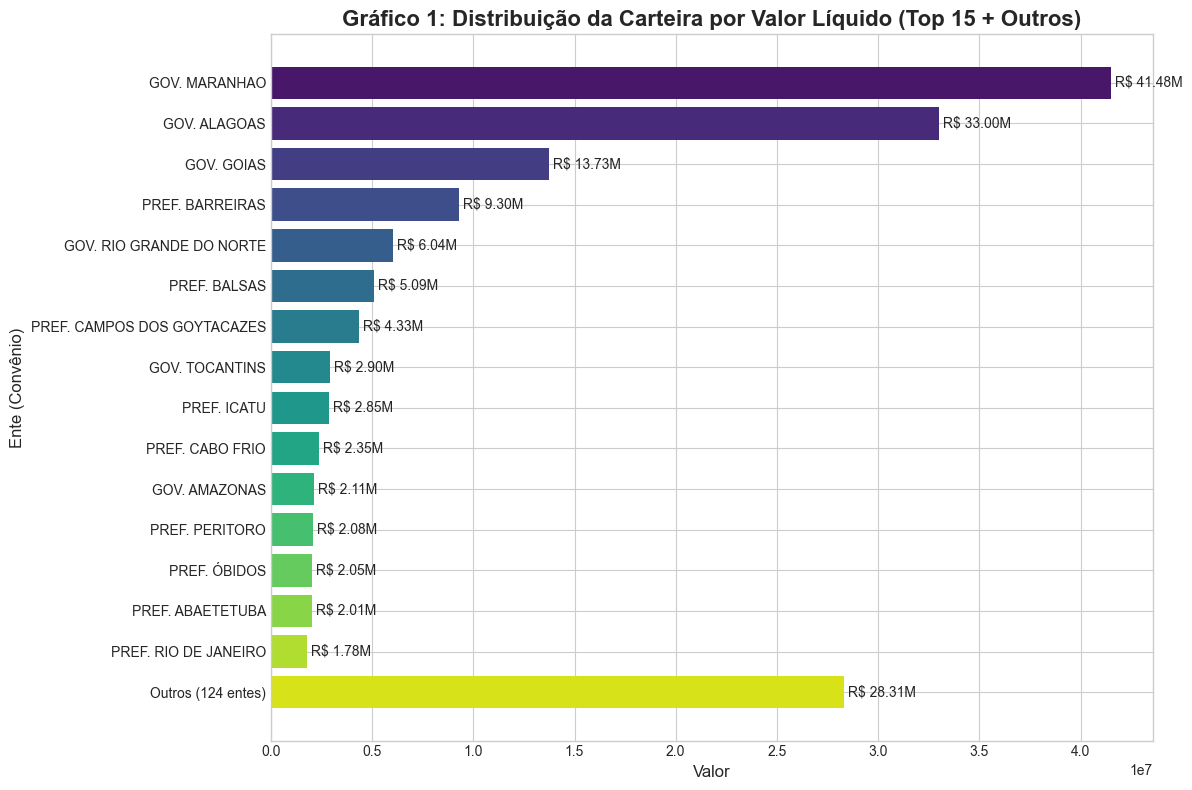


Gerando Gráfico 2: Ranking por Risco...


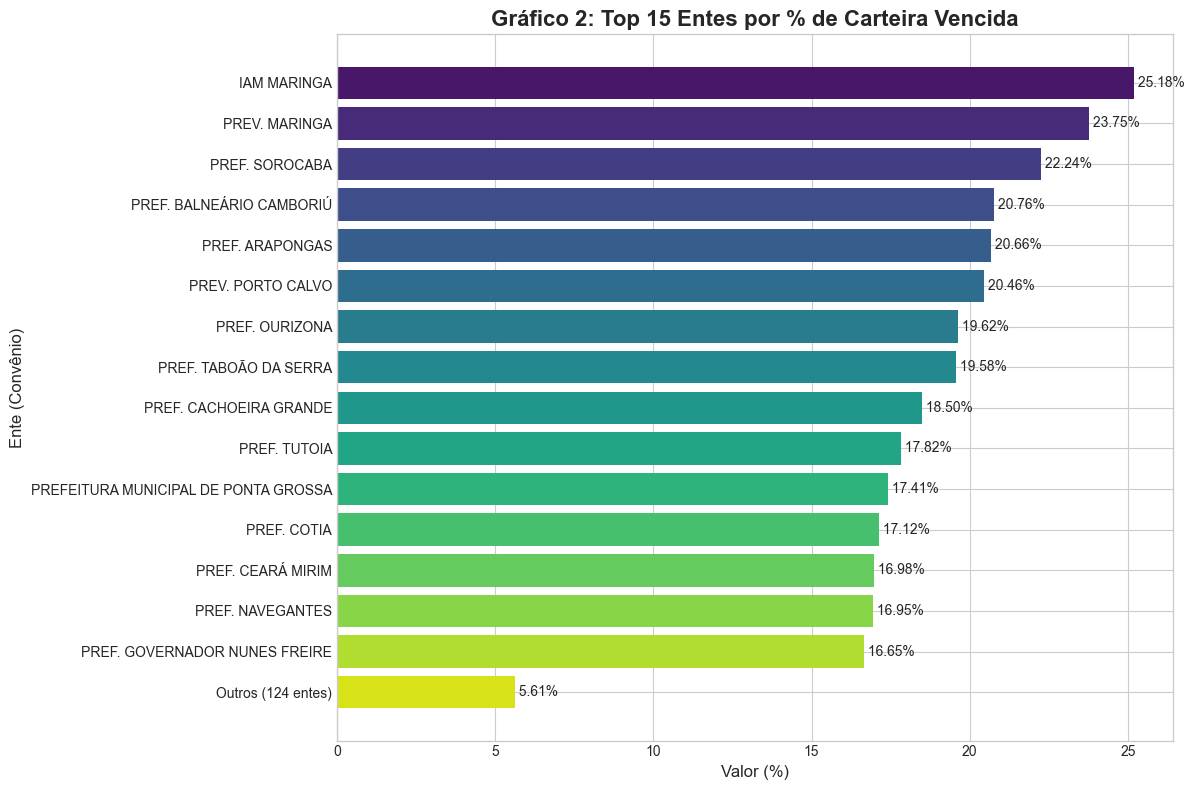

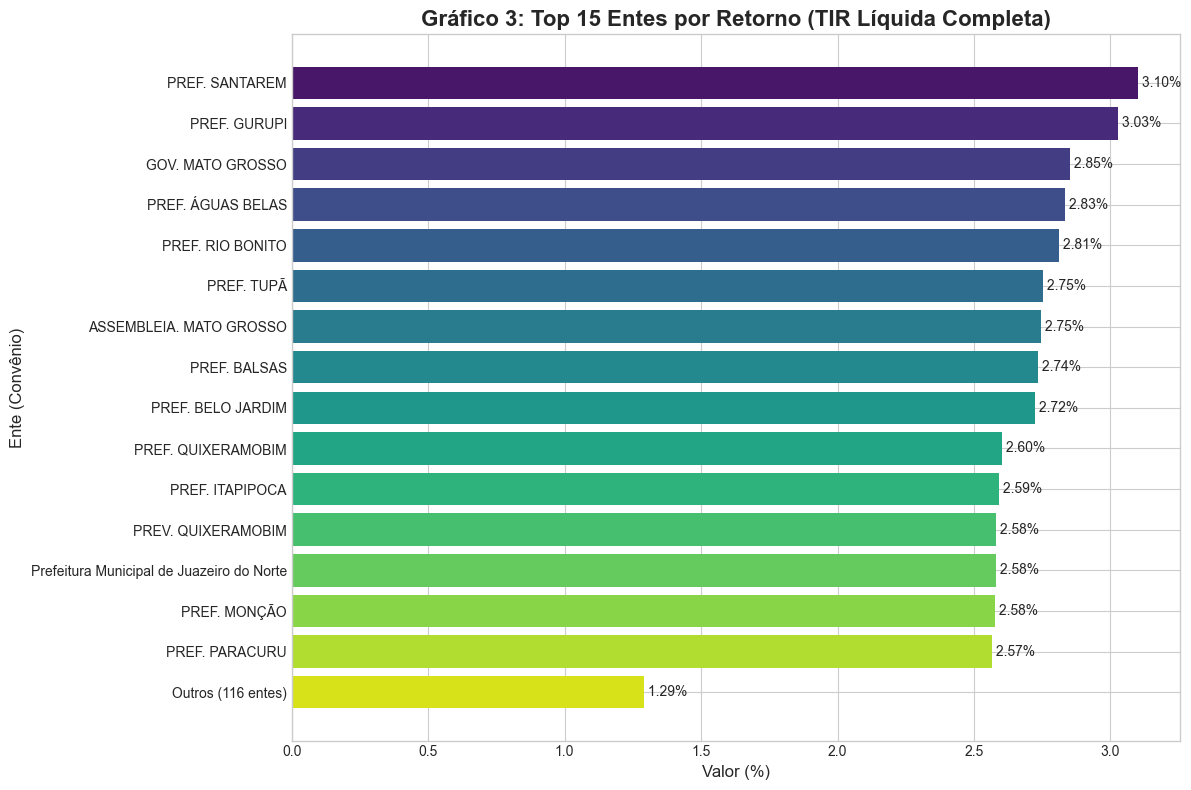


Gerando Gráfico 4: Risco vs. Retorno Simplificado...


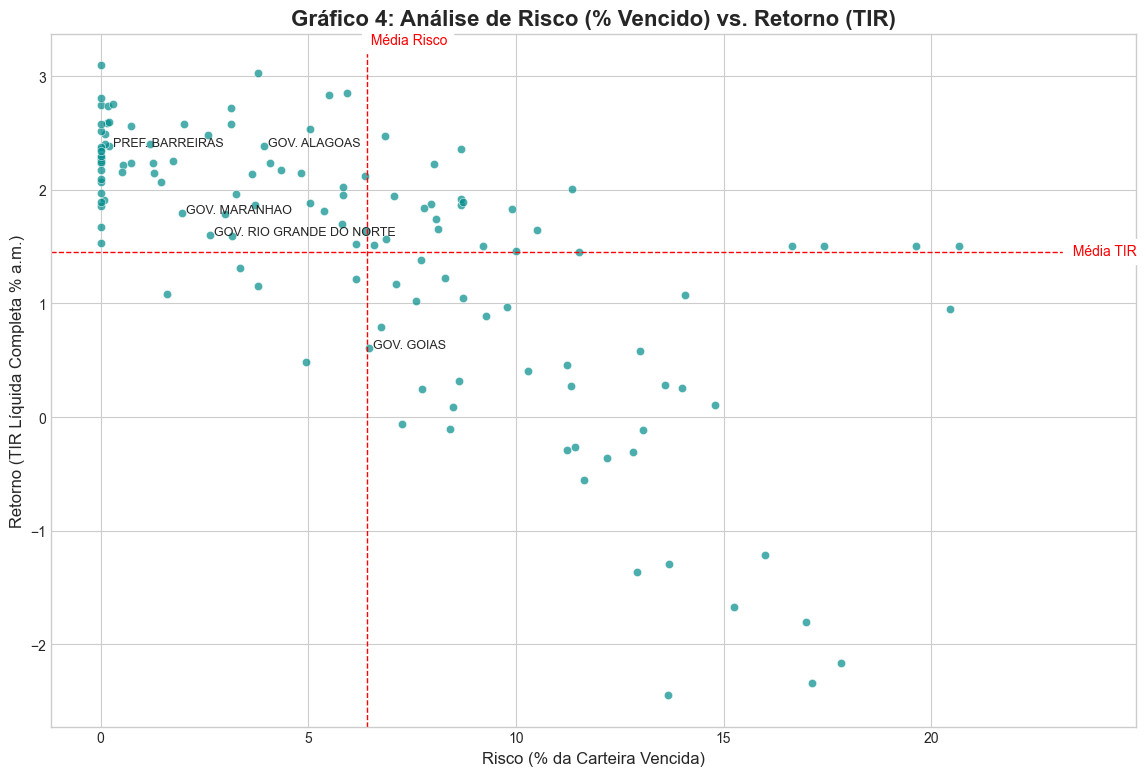

FIM DA GERAÇÃO DE GRÁFICOS


In [ ]:
#| classes: [fold-output] 
# ( saída recolhível)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("="*80)
print("INICIANDO GERAÇÃO DE GRÁFICOS DE DISTRIBUIÇÃO")
print("="*80)



df_resumo_metricas = df_final2.groupby('Convênio').agg(
    ValorPresente=('ValorPresente', 'sum'),
    ValorLiquido=('_ValorLiquido', 'sum'),
    ValorVencido=('_ValorVencido', 'sum'),
    PDDTotal=('PDDTotal', 'sum')
).reset_index()
"""# ---  preprc do datfrm de resmo para os grafcs ---"""

df_resumo_metricas['%Vencido'] = (df_resumo_metricas['ValorVencido'] / df_resumo_metricas['ValorPresente']) * 100
df_resumo_metricas['%PDD'] = (df_resumo_metricas['PDDTotal'] / df_resumo_metricas['ValorPresente']) * 100

df_resumo_tir = df_tir_summary[df_tir_summary['Dimensão'] == 'Convênio'].copy()

df_graficos = pd.merge(
    df_resumo_metricas,
    df_resumo_tir.rename(columns={'Segmento': 'Convênio'}),
    on='Convênio',
    how='left'
)



#####################################################################

def plot_ranking_com_outros(df, metric_col, title, n=15, agg_type='sum', is_percent=False):
    """#  função de plotgm de rankng aprmrd ---"""
    df_sorted = df.dropna(subset=[metric_col]).sort_values(metric_col, ascending=False)
    
    if len(df_sorted) > n:
        df_top = df_sorted.head(n)
        df_others = df_sorted.iloc[n:]
        
        if agg_type == 'sum':
            others_value = df_others[metric_col].sum()
        else: # 'mean'
            others_value = df_others[metric_col].mean()
            
        others_name = f'Outros ({len(df_others)} entes)'
        df_outros = pd.DataFrame([{'Convênio': others_name, metric_col: others_value}])
        df_to_plot = pd.concat([df_top, df_outros], ignore_index=True)
    else:
        df_to_plot = df_sorted

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 8))
    bars = plt.barh(df_to_plot['Convênio'], df_to_plot[metric_col], color=sns.color_palette("viridis", len(df_to_plot)))
    plt.gca().invert_yaxis()
    
    for bar in bars:
        width = bar.get_width()
        if pd.isna(width): continue
        label_format = '{:,.2f}%' if is_percent else 'R$ {:,.2f}M'
        label_value = width if is_percent else width / 1e6
        plt.text(width, bar.get_y() + bar.get_height()/2, f' {label_format.format(label_value)}', va='center')
        
    plt.title(title, fontsize=16, weight='bold')
    plt.xlabel('Valor' + (' (%)' if is_percent else ''), fontsize=12)
    plt.ylabel('Ente (Convênio)', fontsize=12)
    plt.tight_layout()
    plt.show()

#? Graficos >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

# *&Composição da Carteira
print("\nGerando Gráfico 1: Distribuição da Carteira por Valor Líquido...")
plot_ranking_com_outros(
    df_graficos, 'ValorLiquido',
    'Gráfico 1: Distribuição da Carteira por Valor Líquido (Top 15 + Outros)',
    n=15, agg_type='sum', is_percent=False
)

# *Ranking por Risco (% Vencido)
print("\nGerando Gráfico 2: Ranking por Risco...")
plot_ranking_com_outros(
    df_graficos, '%Vencido',
    'Gráfico 2: Top 15 Entes por % de Carteira Vencida',
    n=15, agg_type='mean', is_percent=True
)

#*Ranking por Retorno (TIR)
#>>>>>>>== obs filtra os entes com TIR de -100% antes de plotar
df_tir_filtrado = df_graficos[df_graficos['TIR Líquida (PDD & Custos) a.m. (%)'] != -100.0]
plot_ranking_com_outros(
    df_tir_filtrado, 'TIR Líquida (PDD & Custos) a.m. (%)',
    'Gráfico 3: Top 15 Entes por Retorno (TIR Líquida Completa)',
    n=15, agg_type='mean', is_percent=True
)


#* ANALISE DE RISCO vs. RETORNO (adap dashboard)
print("\nGerando Gráfico 4: Risco vs. Retorno Simplificado...")
# Preparo os dados
df_scatter = df_graficos.dropna(subset=['%Vencido', 'TIR Líquida (PDD & Custos) a.m. (%)']).copy()
df_scatter = df_scatter[
    (df_scatter['TIR Líquida (PDD & Custos) a.m. (%)'] != -100.0) &
    (np.isfinite(df_scatter['%Vencido'])) &
    (np.isfinite(df_scatter['TIR Líquida (PDD & Custos) a.m. (%)']))
]

if not df_scatter.empty:
    plt.figure(figsize=(14, 9))
    
    sns.scatterplot(
        data=df_scatter,
        x='%Vencido',
        y='TIR Líquida (PDD & Custos) a.m. (%)',
        color='darkcyan',
        alpha=0.7
    )

    mean_risk = df_scatter['%Vencido'].mean()
    mean_tir = df_scatter['TIR Líquida (PDD & Custos) a.m. (%)'].mean()
    plt.axvline(mean_risk, color='red', linestyle='--', lw=1)
    plt.axhline(mean_tir, color='red', linestyle='--', lw=1)

    plt.text(plt.xlim()[1], mean_tir, ' Média TIR', va='center', ha='right', backgroundcolor='white', color='red')
    plt.text(mean_risk, plt.ylim()[1], ' Média Risco', va='top', ha='left', backgroundcolor='white', color='red')
    
    # anotcs nos ponts para os mars ents- util para identf os ponts chve
    for i, row in df_scatter.nlargest(5, 'ValorLiquido').iterrows():
        plt.text(row['%Vencido'] + 0.1, row['TIR Líquida (PDD & Custos) a.m. (%)'], row['Convênio'], fontsize=9, ha='left')

    plt.title('Gráfico 4: Análise de Risco (% Vencido) vs. Retorno (TIR)', fontsize=16, weight='bold')
    plt.xlabel('Risco (% da Carteira Vencida)', fontsize=12)
    plt.ylabel('Retorno (TIR Líquida Completa % a.m.)', fontsize=12)
    plt.grid(True)
    plt.show()
else:
    print("Não foi possível gerar o gráfico de Risco vs. Retorno pois não há dados suficientes (ou todos foram filtrados).")

print("="*80)
print("FIM DA GERAÇÃO DE GRÁFICOS")
print("="*80)

# Bloco 18: Explicação dos Métodos
 <span style="color:#98FB98;"> - Como a TIR foi calculada</span>

Explicação
## Explicação Geral Sobre o Cálculo da TIR

## Metodologia de Cálculo da Taxa Interna de Retorno (TIR)

### Geral
A fórmula geral que o script resolve para encontrar a TIR é:

$$VPL = \sum_{i=0}^{n} \frac{FC_i}{(1 + \text{TIR})^{d_i/P}} = 0$$

com:
- $FC_i$: É o fluxo de caixa no período $i$. O primeiro fluxo é o investimento inicial (negativo).
- $d_i$: É o nº de dias úteis desde o investimento inicial até o fluxo de caixa $i$.
- $P$:  **21 dias úteis** (período da taxa - mês comercial), resultando em uma TIR mensal.

### Definição das Variáveis usadas

Para cada variável categórica  (carteira total, um convênio ou um cedente- chamarei de "segmento"), as seguintes variáveis são calculadas a partir das parcelas a vencer:

* **$VP_{total}$**: O Valor Presente total do segmento, que representa o investimento inicial (saída de caixa).
* **$VN_i$**: O Valor Nominal da $i$-ésima parcela futura.
* **$PDD_{total}$**: A soma da Provisão para Devedores Duvidosos do segmento.
* **$C_i$**: O Custo Total (fixo + variável) associado à $i$-ésima parcela.
* **$RL_i$**: A Receita Líquida da $i$-ésima parcela, calculada como $RL_i = VN_i - C_i$.
* **$R_{PDD}$**: A taxa de PDD do segmento, calculada como $R_{PDD} = \frac{PDD_{total}}{VP_{total}}$.

Abaixo, a fórmula para cada uma das quatro TIRs calculadas.

### TIR Bruta a.m. (%)

Assume que todas as parcelas futuras serão recebidas em seu valor nominal completo, sem perdas por inadimplência ou custos operacionais (ideal).

* **Saída de Caixa (t=0):** $-VP_{total}$
* **Entradas de Caixa (t > 0):** $VN_i$

A equação resolvida é:
$$0 = -VP_{total} + \sum_{i=1}^{n} \frac{VN_i}{(1 + \text{TIR}_{\text{Bruta}})^{d_i/21}}$$

---

### TIR Líquida (PDD) a.m. (%)

Esta rentabilidade é ajustada pelo risco de crédito esperado. Ela mostra o retorno após considerar as perdas (projetadas) pela PDD. O investimento inicial não é alterado, mas o retorno futuro esperado é reduzido.

* **Saída de Caixa (t=0):** $-VP_{total}$
* **Entradas de Caixa (t > 0):** $VN_i \times (1 - R_{PDD})$

A equação resolvida é:
$$0 = -VP_{total} + \sum_{i=1}^{n} \frac{VN_i \times (1 - R_{PDD})}{(1 + \text{TIR}_{\text{PDD}})^{d_i/21}}$$

---

###  TIR Líquida (Custos) a.m. (%)

Esta rentabilidade é ajustada pelos custos operacionais. 

* **Saída de Caixa (t=0):** $-VP_{total}$
* **Entradas de Caixa (t > 0):** $RL_i$ (Receita Líquida)

A equação resolvida é:
$$0 = -VP_{total} + \sum_{i=1}^{n} \frac{RL_i}{(1 + \text{TIR}_{\text{Custos}})^{d_i/21}}$$

---

### TIR Líquida (PDD & Custos) a.m. (%)

Esta é a visão mais conservadora e completa, ajusta a rentabilidade tanto pelo risco de crédito quanto pelos custos operacionais.

* **Saída de Caixa (t=0):** $-VP_{total}$
* **Entradas de Caixa (t > 0):** $RL_i \times (1 - R_{PDD})$

A equação resolvida é:
$$0 = -VP_{total} + \sum_{i=1}^{n} \frac{RL_i \times (1 - R_{PDD})}{(1 + \text{TIR}_{\text{Completa}})^{d_i/21}}$$

---
---

## Mapeamento das Variáveis do Código para as Fórmulas

### DataFrames Principais

* `df_final2`: É o DataFrame principal que contém todos os dados da carteira após a limpeza inicial.
* `df_avencer`: É um subconjunto de `df_final2`, contendo apenas as parcelas com data de vencimento futura (`DataVencimento > ref_date`). É a base para todos os cálculos de TIR.
* `df_segmento`: Dentro do loop de análise, esta variável representa a "fatia" de `df_avencer` que corresponde ao segmento sendo analisado no momento (variável categ.).

### Variáveis de Cálculo (Dentro do Loop por Segmento)

| Variável no Código | Símbolo na Fórmula | Descrição e Cálculo |
| :--- | :--- | :--- |
| `vp_bruto` | $VP_{total}$ | O **Valor Presente** total do segmento, que representa o investimento inicial. É calculado como: `df_segmento['ValorPresente'].sum()`. |
| `pdd_total` | $PDD_{total}$ | A **Provisão para Devedores Duvidosos** total do segmento. Calculada como: `df_segmento['PDDTotal'].sum()`. |
| `pdd_rate` | $R_{PDD}$ | A **taxa de PDD** do segmento, que representa a perda esperada em relação ao valor presente. Calculada como: `pdd_total / vp_bruto`. |
| `df_avencer['_DIAS_UTEIS_']`| $d_i$ | Coluna com o número de **dias úteis** entre a data de referência e a data de vencimento de cada parcela `i`. |
| `df_avencer['CustoTotal']`| $C_i$ | Coluna com o **Custo Total** para cada parcela `i`, somando os custos fixos e variáveis. |
| `df_avencer['ReceitaLiquida']`| $RL_i$ | Coluna com a **Receita Líquida** para cada parcela `i`, calculada como `ValorNominal - CustoTotal`. |

### Construção do Fluxo de Caixa para a Função `calculate_xirr`

A função `calculate_xirr(cash_flows, days)` espera receber duas listas: uma com os valores e outra com os dias. O script as constrói da seguinte forma:

* **Fluxos de Caixa Futuros (Ex: `fluxos_brutos`)**:
    * É uma série `pandas` resultante de agrupar as parcelas por `_DIAS_UTEIS_` e somar os valores correspondentes (ex: `ValorNominal` para a TIR Bruta). O índice da série são os dias e os valores são os recebimentos totais naquele dia.
    * **Código:** `df_segmento.groupby('_DIAS_UTEIS_')['ValorNominal'].sum()`

* **Lista `cash_flows` (para a função):**
    * É A lista completa de fluxos de caixa.
    * **Código:** `[-vp_bruto] + fluxos_brutos.values.tolist()`
    * **Explicação:** O primeiro elemento é o investimento inicial **negativo** ($FC_0 = -VP_{total}$), seguido pelos recebimentos futuros.

* **Lista `days` (para a função):**
    * É A lista de tempo em dias úteis para cada fluxo de caixa.
    * **Código:** `[0] + fluxos_brutos.index.tolist()`
    * **Explicação:** O primeiro elemento é o dia 0 ($d_0 = 0$) para o investimento, seguido pelos dias úteis em que os recebimentos ocorrem.